In [112]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.preprocessing.sequence
import math
import warnings
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import signal
from tqdm import tqdm
import ast

In [113]:
sr = 100
quick_load = True

In [114]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    def load_data():
        ptb = pd.read_csv('../data/ptbxl_database.csv')
        def load_raw_data(df, sampling_rate, path):
            if(sampling_rate == 100):
                data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data
        
        # load and convert annotation data
        Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sr, '../data/')

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in agg_df.index:
                    tmp.append(agg_df.loc[key].diagnostic_class)
            return list(set(tmp))


        # Apply diagnostic superclass
        Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
        return X, Y

In [115]:
if(quick_load):
    X = np.load('../data/X_raw.npy')
    Y = pd.read_csv('../data/Y_raw.csv')
else:
    X,Y = load_data()

In [116]:
def subset_age(X, Y, age_lower, age_upper):
    X2 = X[(Y.age < age_upper) & (Y.age >= age_lower)]
    Y2 = Y[(Y.age < age_upper) & (Y.age >= age_lower)]
    X_sub = X2[Y2.diagnostic_superclass == "['NORM']"]
    Y_sub = X2[Y2.diagnostic_superclass == "['NORM']"]
    return X_sub, Y_sub

X_sub, Y_sub = subset_age(X, Y, 70, 89)


In [117]:
len(X_sub)

1466

In [118]:
(Y.diagnostic_superclass).unique()

array(["['NORM']", "['MI']", '[]', "['STTC']", "['HYP']", "['CD']",
       "['MI', 'STTC']", "['CD', 'HYP']", "['CD', 'MI']",
       "['CD', 'STTC']", "['MI', 'HYP']", "['MI', 'STTC', 'HYP']",
       "['CD', 'MI', 'HYP', 'STTC']", "['STTC', 'HYP']", "['CD', 'NORM']",
       "['STTC', 'MI', 'HYP']", "['CD', 'MI', 'STTC']",
       "['STTC', 'HYP', 'CD']", "['CD', 'STTC', 'HYP']",
       "['STTC', 'MI', 'HYP', 'CD']", "['NORM', 'STTC']",
       "['CD', 'HYP', 'STTC']", "['CD', 'MI', 'HYP']",
       "['CD', 'MI', 'STTC', 'HYP']", "['CD', 'NORM', 'STTC']",
       "['CD', 'NORM', 'HYP']", "['NORM', 'HYP']",
       "['CD', 'NORM', 'MI', 'HYP']"], dtype=object)

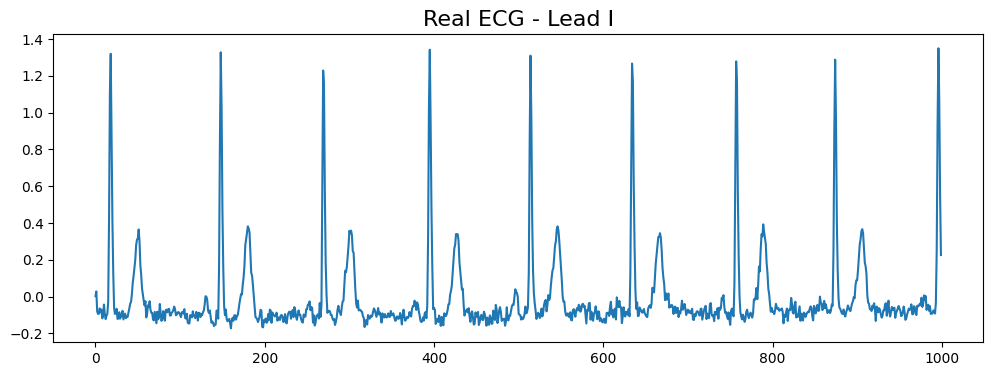

In [119]:
plt.figure(figsize=(12,4))
plt.title("Real ECG - Lead I", fontsize=16)
plt.plot(X_sub[0,:,0])
plt.show()

### Generator Utility Functions

In [120]:
# generate n real samples with class labels
def generate_real_samples(ecgsignal,n):
    """Randomly pick n real ECG samples from the dataset and return it together with an array of n ones """
    # generate inputs in [-0.5, 0.5]
    X = ecgsignal[np.random.choice(ecgsignal.shape[0],n)]
    # generate class labels
    y = tf.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    """Generate random numbers used as input to the generator """
    # generate points in the latent space
    x_in = np.random.randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the network
    return np.expand_dims(x_in,1)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(latent_dim,generator,n):
    """Use the generator to generate fake ECGs"""
    # generate points in latent space
    x_input = generate_latent_points(latent_dim,n)
    # predict outputs
    X = generator(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

def compare_real_and_gen_ecg(generated_ecg):
    """Plot real and generated ECGs side by side"""
    plt.figure(figsize=(24,4))
    plt.subplot(1,2,1)
    plt.title("Generated (fake) ECG - Lead I", fontsize=16)
    plt.plot(generated_ecg[0,:,0])
    plt.subplot(1,2,2)
    plt.title("Real ECG - Lead I", fontsize=16)
    rand_idx = np.random.choice(np.arange(len(X_sub)))
    plt.plot(X_sub[rand_idx,:,0])
    plt.show()

### Inception Model

In [121]:
def _inception_module(
    input_tensor,
    stride=1,
    activation="linear",
    use_bottleneck=True,
    kernel_size=40,
    bottleneck_size=32,
    nb_filters=32,
):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(
            filters=bottleneck_size,
            kernel_size=1,
            padding="same",
            activation=activation,
            use_bias=False,
        )(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2**i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(
            tf.keras.layers.Conv1D(
                filters=nb_filters,
                kernel_size=kernel_size_s[i],
                strides=stride,
                padding="same",
                activation=activation,
                use_bias=False,
            )(input_inception)
        )

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(
        input_tensor
    )

    conv_6 = tf.keras.layers.Conv1D(
        filters=nb_filters,
        kernel_size=1,
        padding="same",
        activation=activation,
        use_bias=False,
    )(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation="relu")(x)
    return x


def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(
        filters=int(out_tensor.shape[-1]), kernel_size=1, padding="same", use_bias=False
    )(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation("relu")(x)
    return x


def discriminator(
    input_shape = (1000,12),
    nb_classes=1,
    depth: int = 1,
    use_residual: bool = True,
)-> tf.keras.models.Model:
    """
    Model proposed by HI Fawas et al 2019 "Finding AlexNet for Time Series Classification - InceptionTime"
    """
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes, activation="sigmoid")(
        gap_layer
    )

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanSquaredError()],
    )

    return model


In [122]:
desc = discriminator()
print("Discriminator architecture:")
print(desc.summary())

Discriminator architecture:
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 input_6 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 conv1d_25 (Conv1D)             (None, 1000, 32)     384         ['input_6[0][0]']                
                                                                                                  
 max_pooling1d_5 (MaxPooling1D)  (None, 1000, 12)    0           ['input_6[0][0]']                
                                                                                                  
 conv1d_26 (Conv1D)             (None, 1000, 32)     40960       ['conv1d_25[0][0]']              
                                                                                                  
 conv1d_27 (Conv1D)             (None, 1000, 32)     20480       ['conv1d_25[0][0]']              
                                                                                                  
 conv1d_28

In [123]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12*1000, use_bias=False, input_shape=(1,12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((1000,12)))
    assert model.output_shape == (None, 1000, 12)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv1DTranspose(128, 5, strides= 1, padding='same', use_bias=False))
    assert model.output_shape == (None, 1000, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(64,  5, strides= 1, padding='same', use_bias=False))
    assert model.output_shape == (None, 1000, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv1DTranspose(12, 5, strides=1, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 1000, 12)
    return model

In [124]:
gen = generator()
print("Generator architecture:")
print(gen.summary())

Generator architecture:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1, 12000)          144000    
                                                                 
 batch_normalization_21 (Bat  (None, 1, 12000)         48000     
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 1, 12000)          0         
                                                                 
 reshape_5 (Reshape)         (None, 1000, 12)          0         
                                                                 
 conv1d_transpose_15 (Conv1D  (None, 1000, 128)        7680      
 Transpose)                                                      
                                                                 
 batch_normalization_22 (Bat  

Before training:


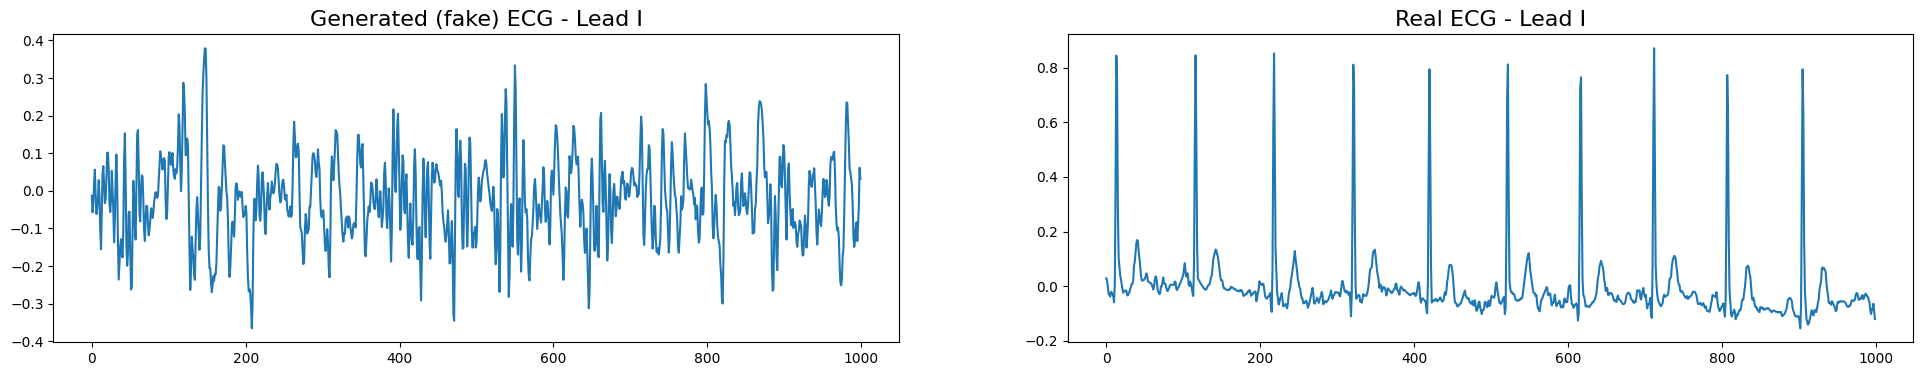

-------------------
epoch 0
epoch 1


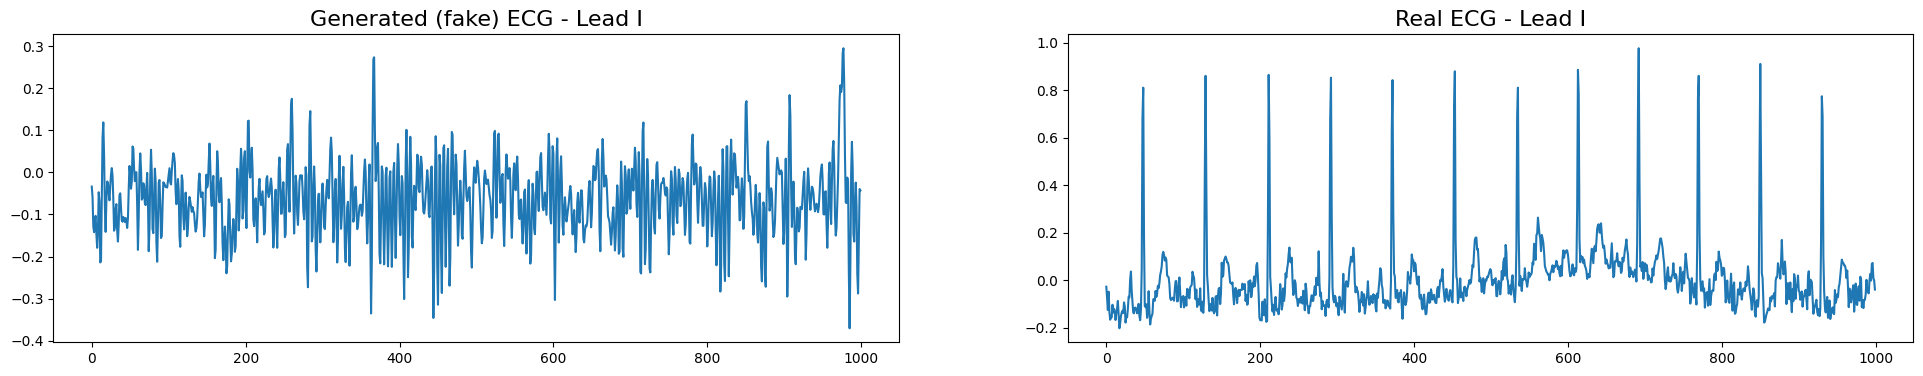

Generator AUROC: 0.578125
Generator loss: 0.7796587
Descriminator AUROC: 0.43505859375
Descriminator loss: 0.7004165
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11


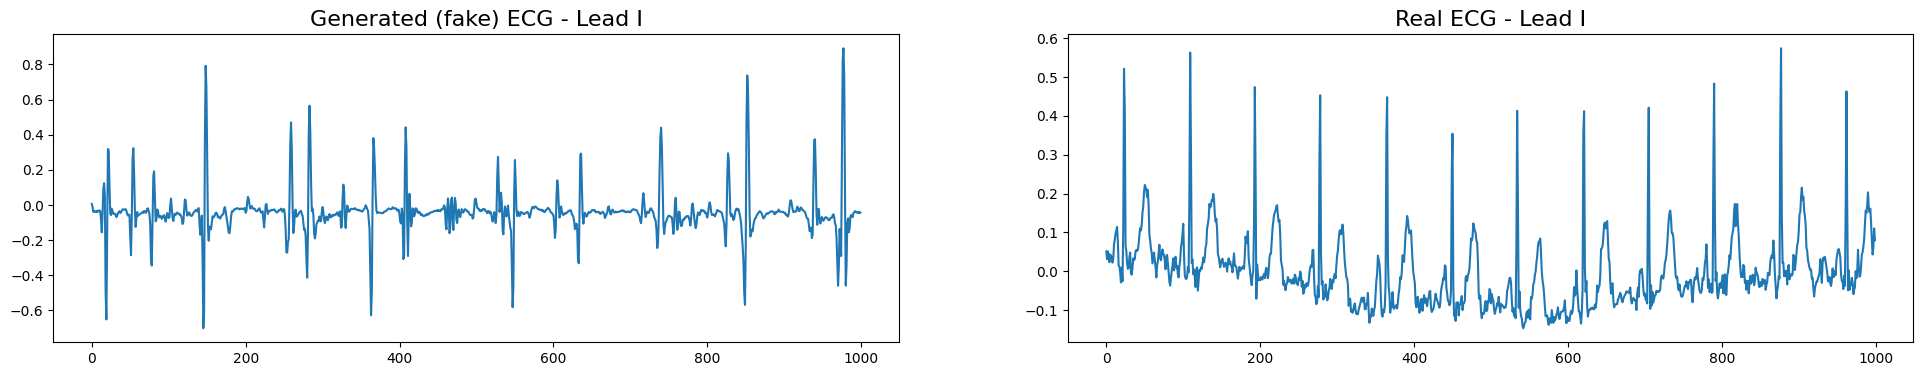

Generator AUROC: 0.0
Generator loss: 0.7781132
Descriminator AUROC: 0.521484375
Descriminator loss: 0.693193
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21


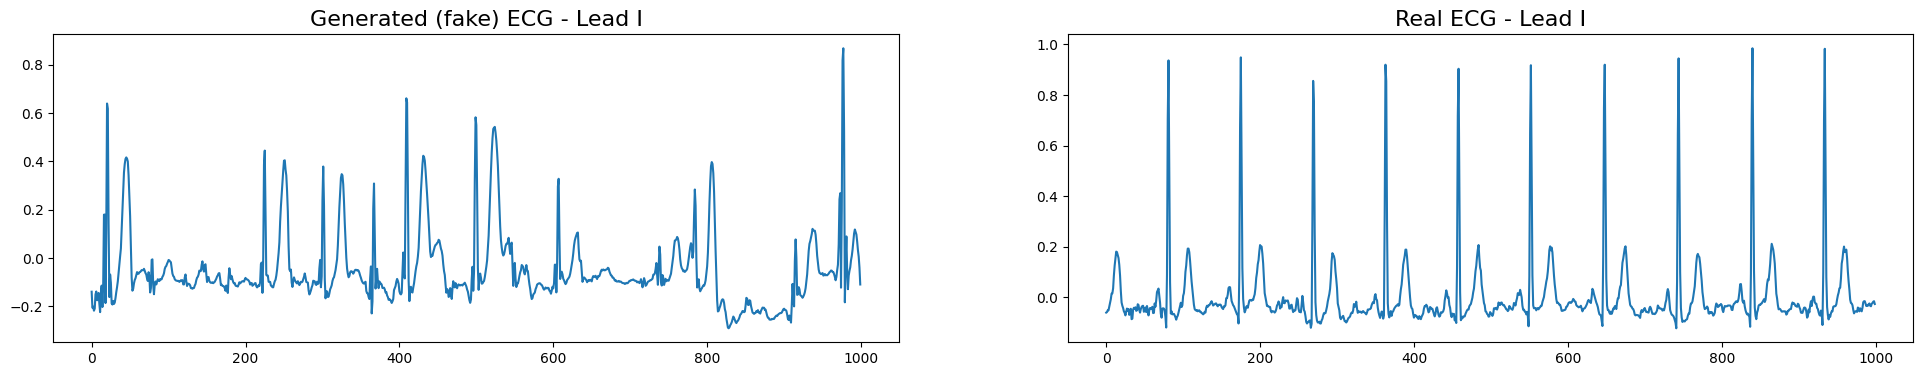

Generator AUROC: 0.171875
Generator loss: 0.70853335
Descriminator AUROC: 0.57421875
Descriminator loss: 0.7003537
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31


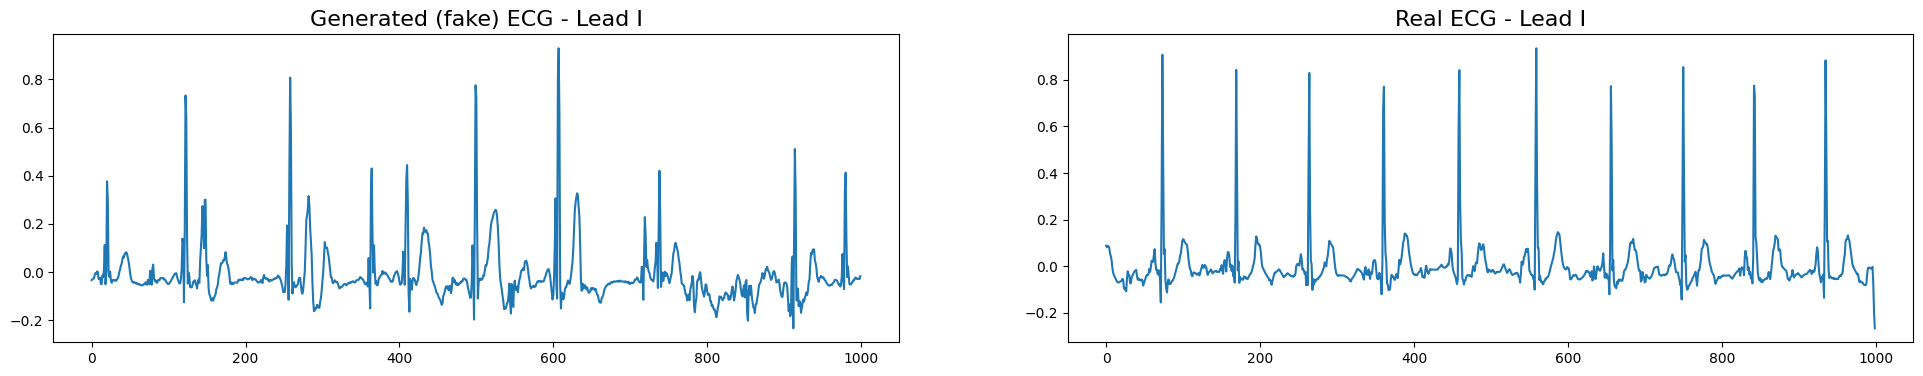

Generator AUROC: 1.0
Generator loss: 0.7333803
Descriminator AUROC: 0.5712890625
Descriminator loss: 0.6909964
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41


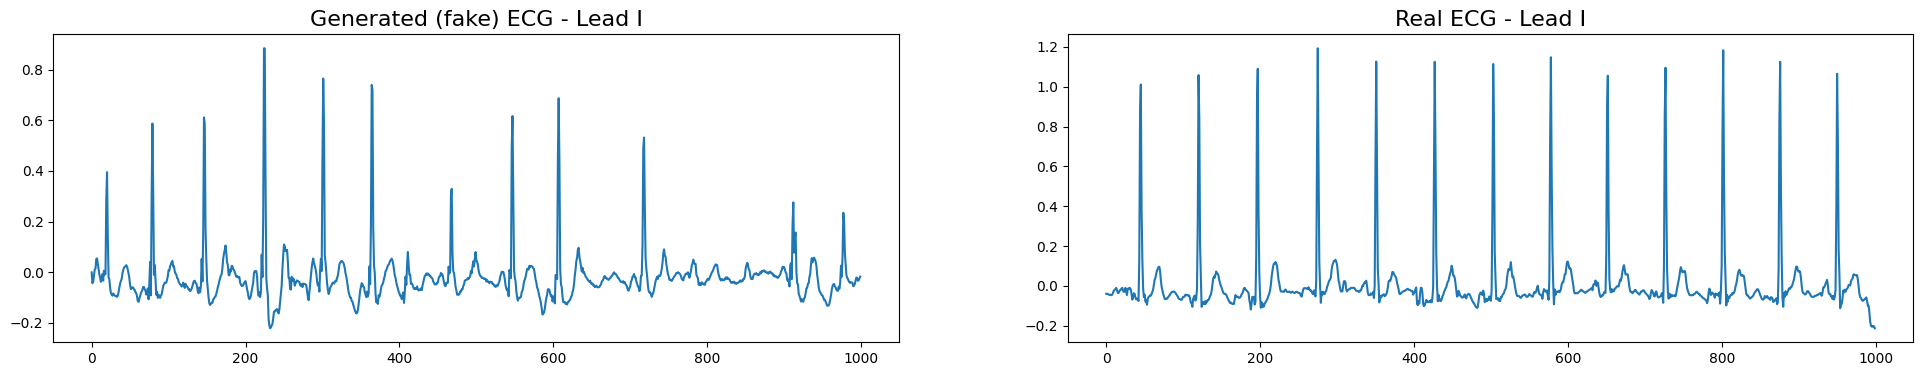

Generator AUROC: 0.0625
Generator loss: 0.7222871
Descriminator AUROC: 0.44140625
Descriminator loss: 0.69326454
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51


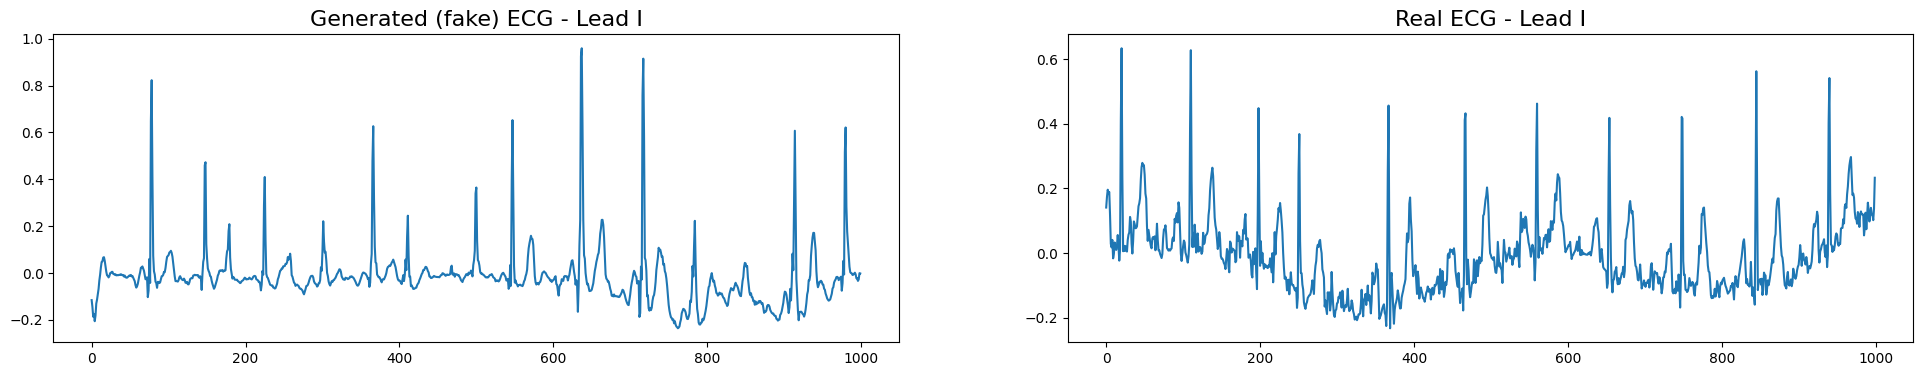

Generator AUROC: 0.046875
Generator loss: 0.7029758
Descriminator AUROC: 0.5576171875
Descriminator loss: 0.68837684
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61


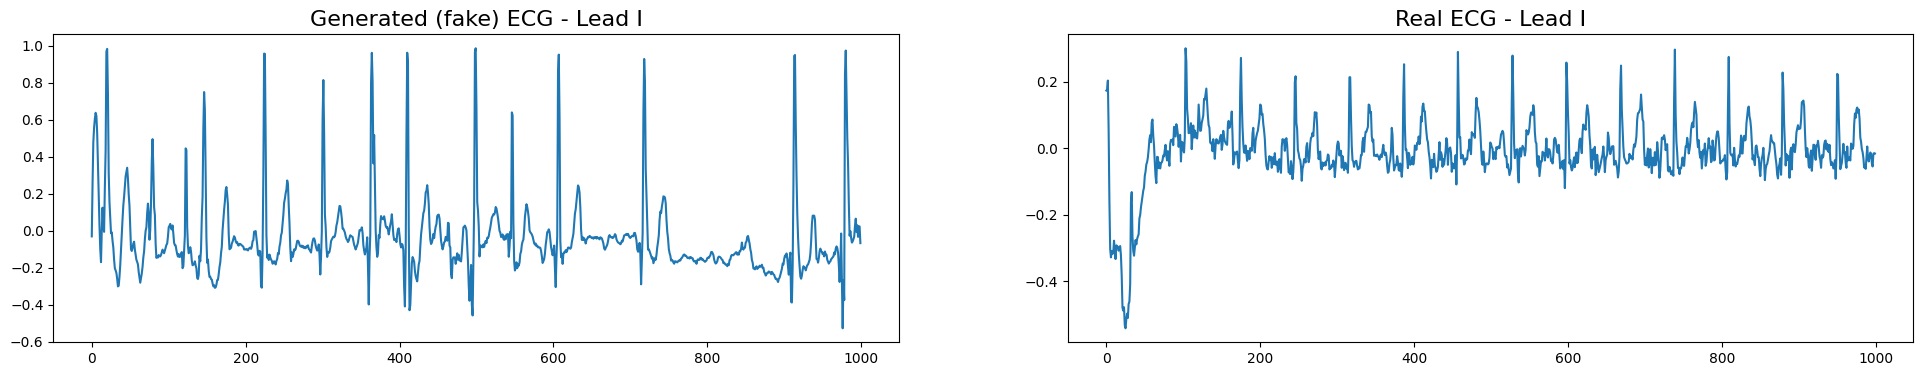

Generator AUROC: 0.5
Generator loss: 0.68550473
Descriminator AUROC: 0.5458984375
Descriminator loss: 0.69637275
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71


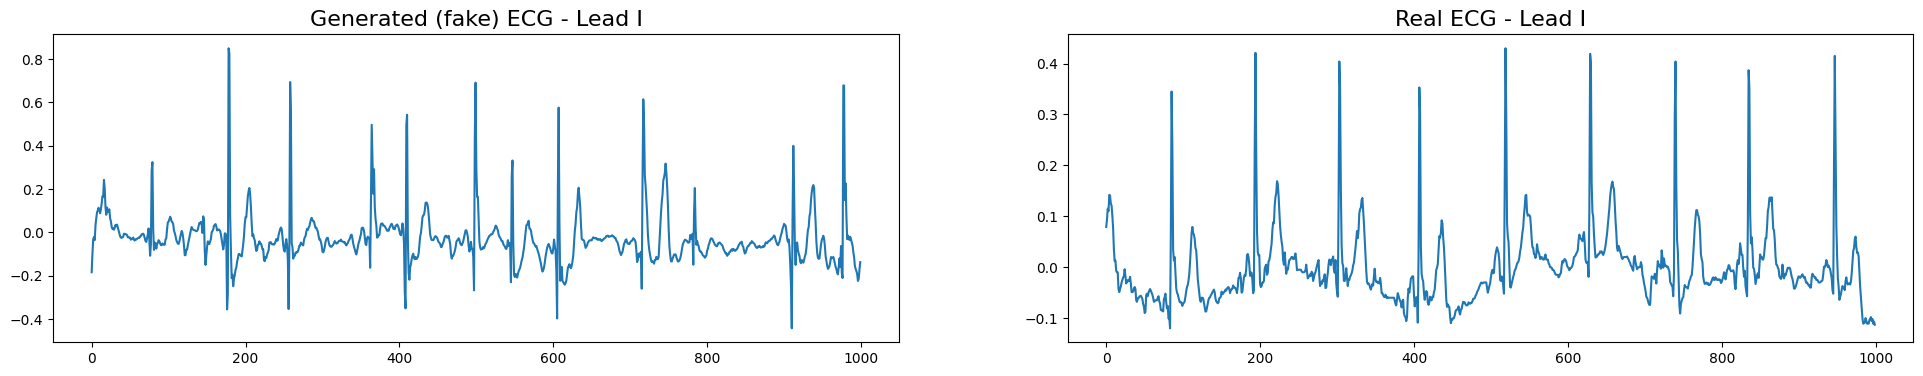

Generator AUROC: 0.0
Generator loss: 0.6937161
Descriminator AUROC: 0.56103515625
Descriminator loss: 0.6936785
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81


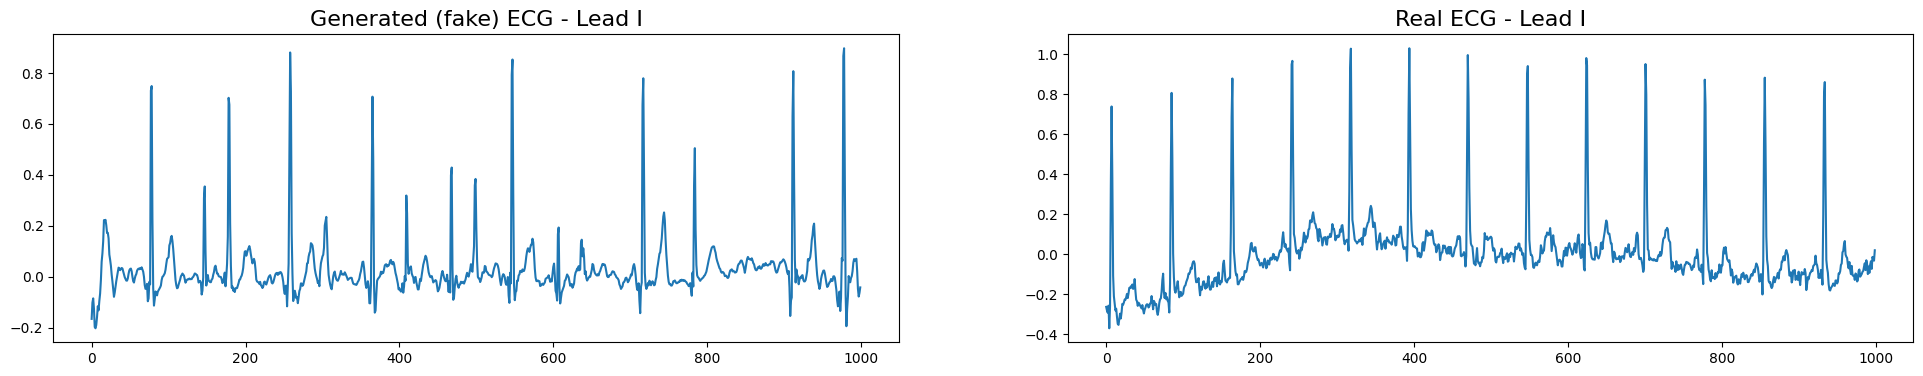

Generator AUROC: 0.25
Generator loss: 0.6923492
Descriminator AUROC: 0.37109375
Descriminator loss: 0.69227105
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91


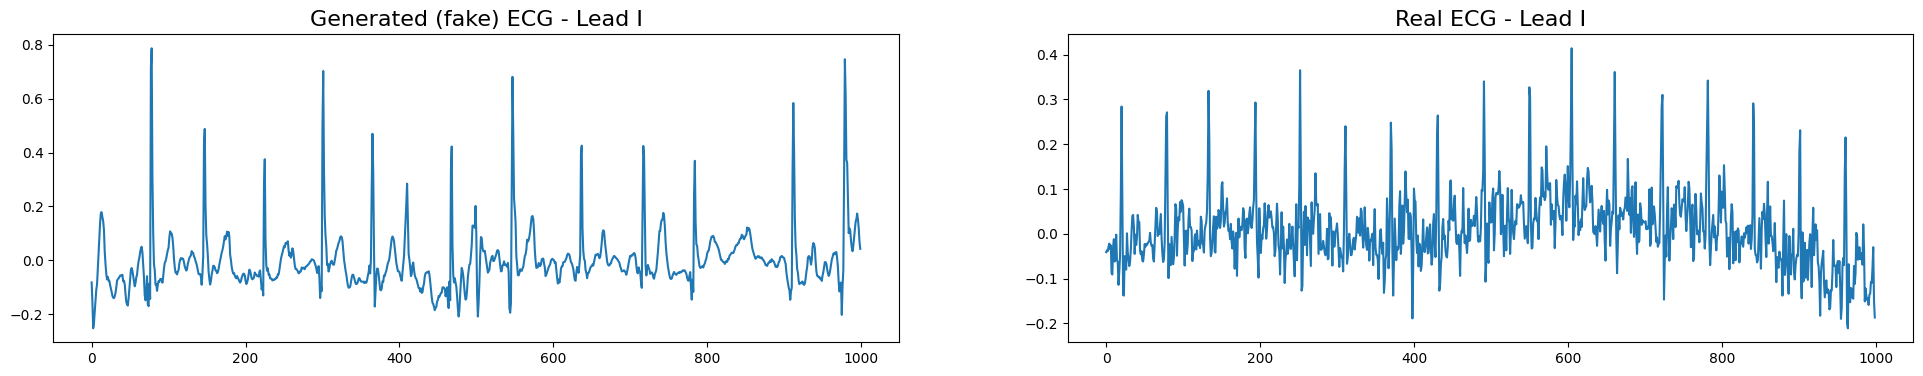

Generator AUROC: 0.328125
Generator loss: 0.6967602
Descriminator AUROC: 0.5234375
Descriminator loss: 0.6912574
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101


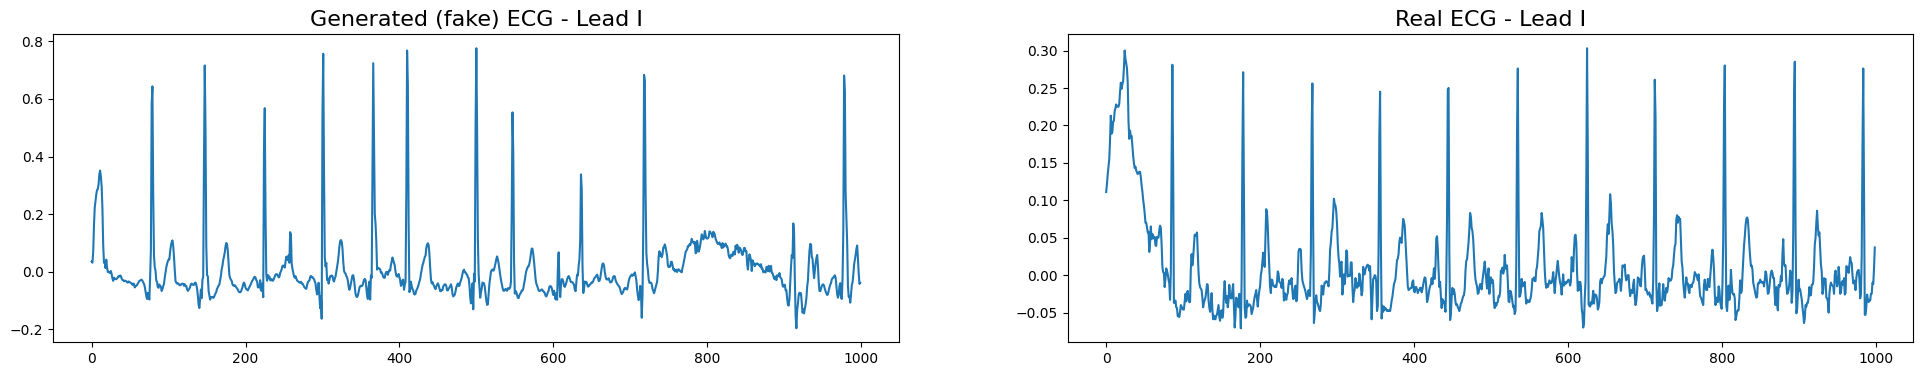

Generator AUROC: 0.53125
Generator loss: 0.6938601
Descriminator AUROC: 0.5556640625
Descriminator loss: 0.6944494
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110
epoch 111


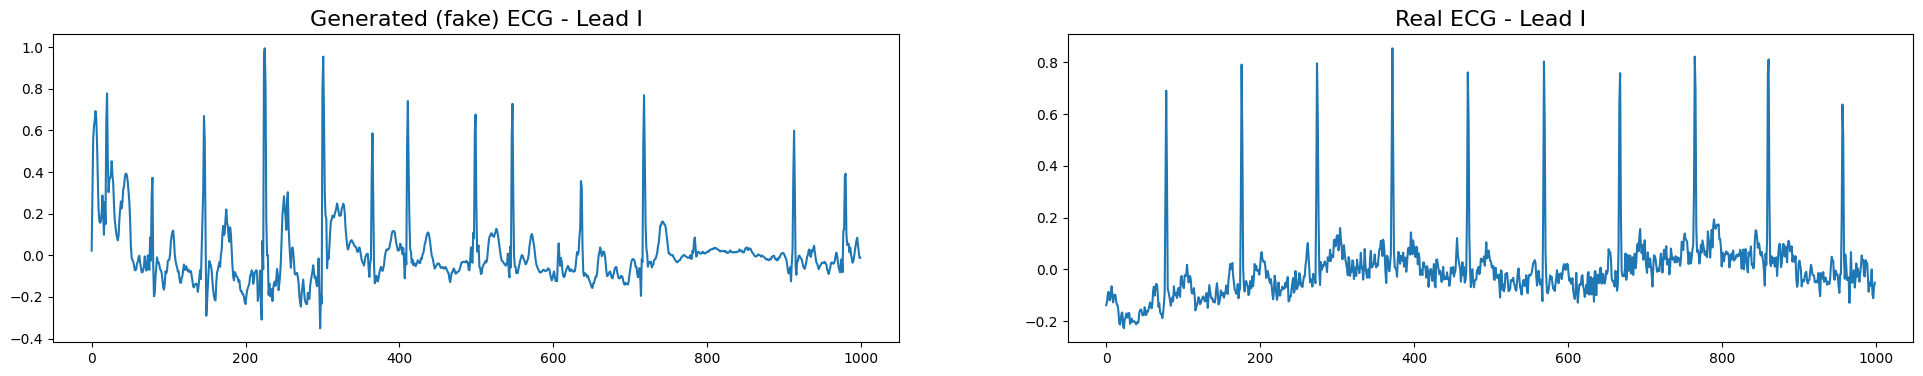

Generator AUROC: 0.703125
Generator loss: 0.6861703
Descriminator AUROC: 0.453125
Descriminator loss: 0.69600815
epoch 112
epoch 113
epoch 114
epoch 115
epoch 116
epoch 117
epoch 118
epoch 119
epoch 120
epoch 121


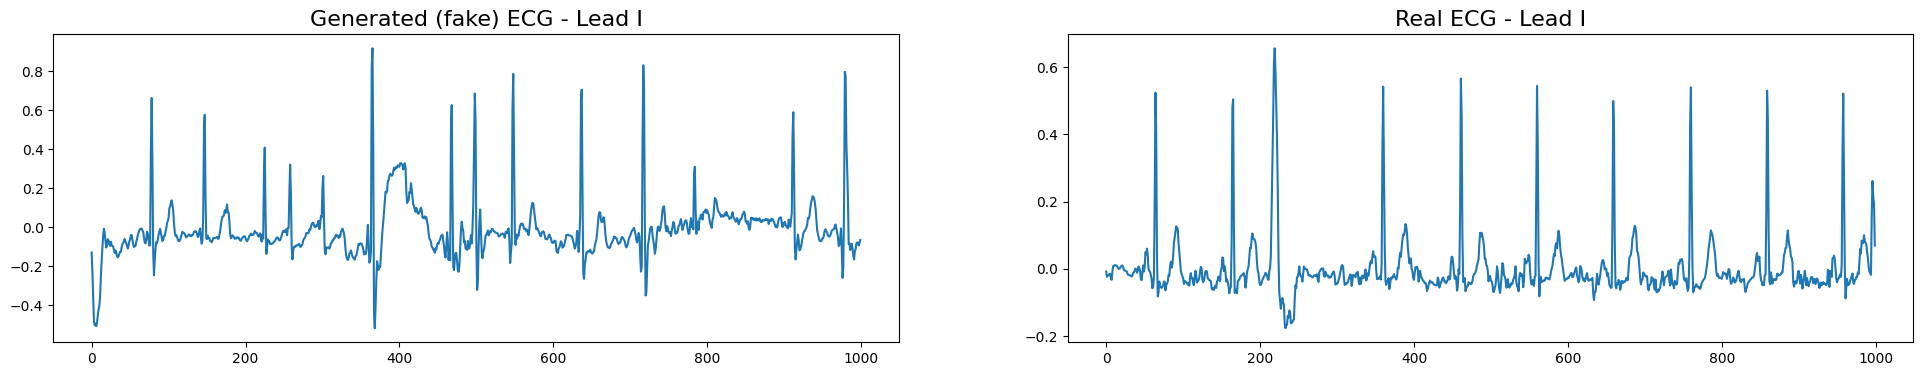

Generator AUROC: 0.9375
Generator loss: 0.68945014
Descriminator AUROC: 0.3603515625
Descriminator loss: 0.69229984
epoch 122
epoch 123
epoch 124
epoch 125
epoch 126
epoch 127
epoch 128
epoch 129
epoch 130
epoch 131


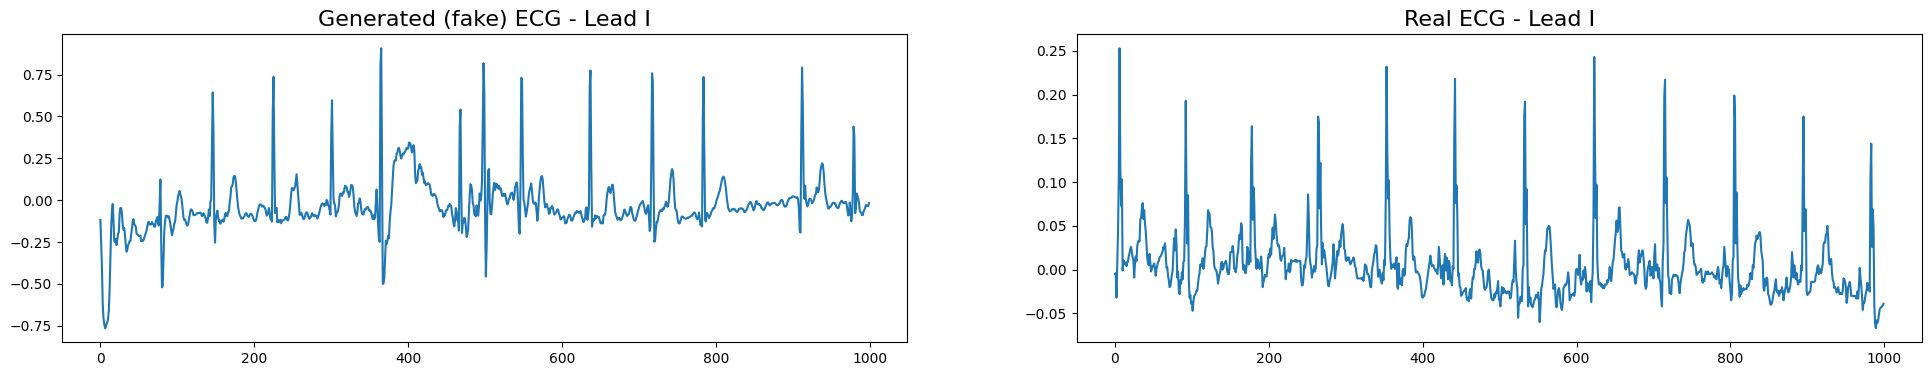

Generator AUROC: 0.90625
Generator loss: 0.6880256
Descriminator AUROC: 0.52587890625
Descriminator loss: 0.69530386
epoch 132
epoch 133
epoch 134
epoch 135
epoch 136
epoch 137
epoch 138
epoch 139
epoch 140
epoch 141


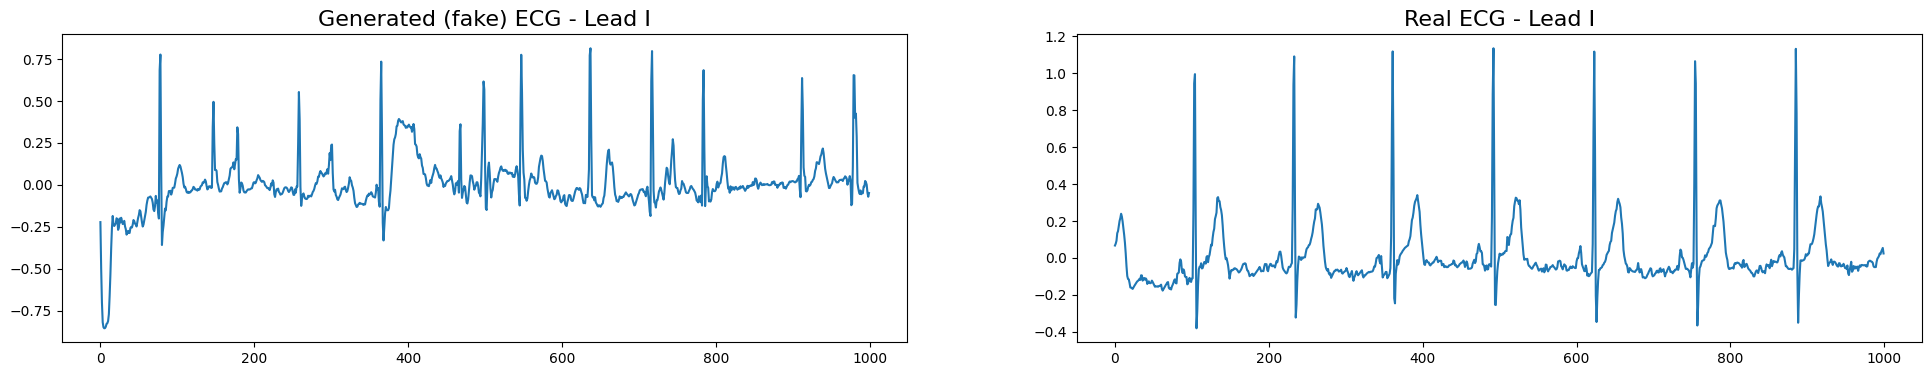

Generator AUROC: 0.703125
Generator loss: 0.6899534
Descriminator AUROC: 0.470703125
Descriminator loss: 0.69396824
epoch 142
epoch 143
epoch 144
epoch 145
epoch 146
epoch 147
epoch 148
epoch 149
epoch 150
epoch 151


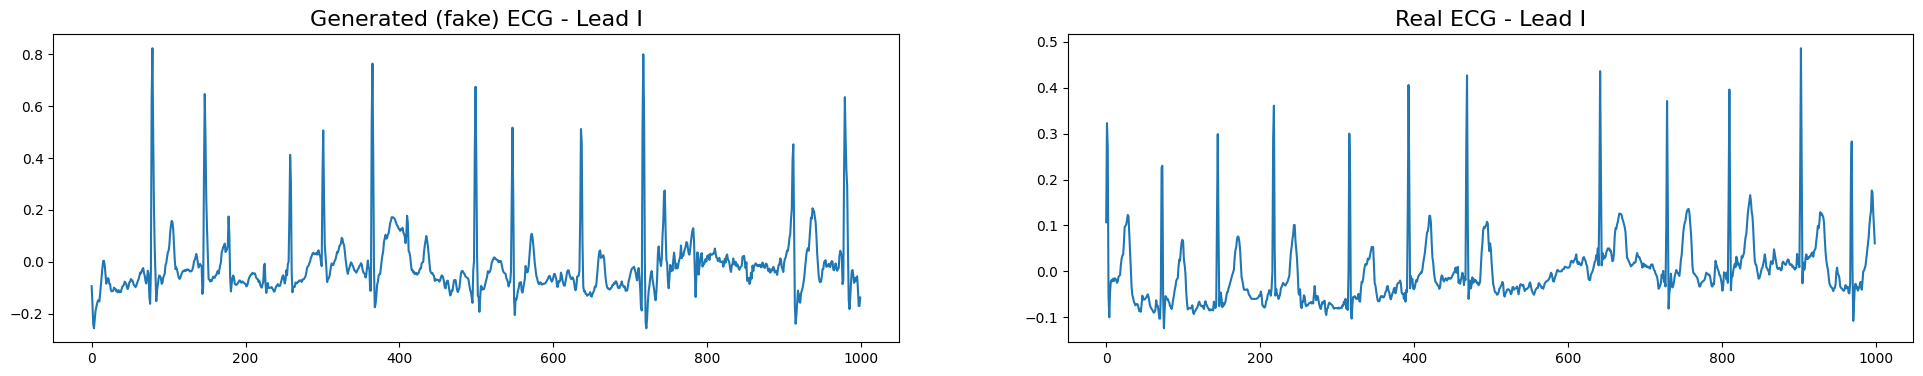

Generator AUROC: 0.953125
Generator loss: 0.6903663
Descriminator AUROC: 0.607421875
Descriminator loss: 0.6939535
epoch 152
epoch 153
epoch 154
epoch 155
epoch 156
epoch 157
epoch 158
epoch 159
epoch 160
epoch 161


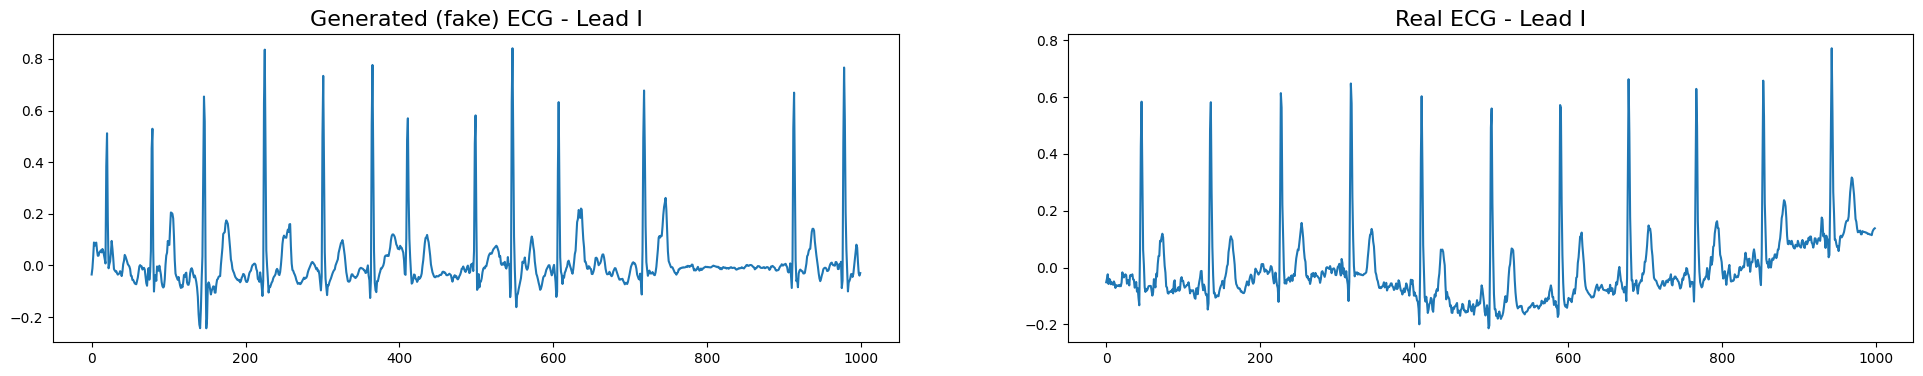

Generator AUROC: 0.15625
Generator loss: 0.6957816
Descriminator AUROC: 0.578125
Descriminator loss: 0.692941
epoch 162
epoch 163
epoch 164
epoch 165
epoch 166
epoch 167
epoch 168
epoch 169
epoch 170
epoch 171


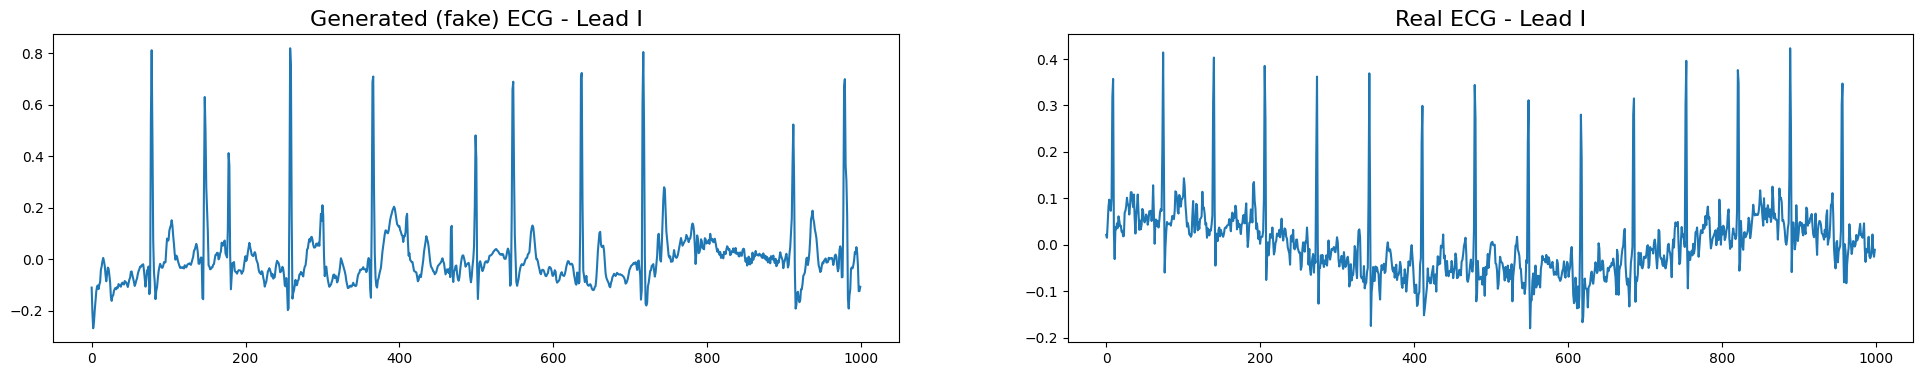

Generator AUROC: 0.296875
Generator loss: 0.69416136
Descriminator AUROC: 0.40234375
Descriminator loss: 0.6935365
epoch 172
epoch 173
epoch 174
epoch 175
epoch 176
epoch 177
epoch 178
epoch 179
epoch 180
epoch 181


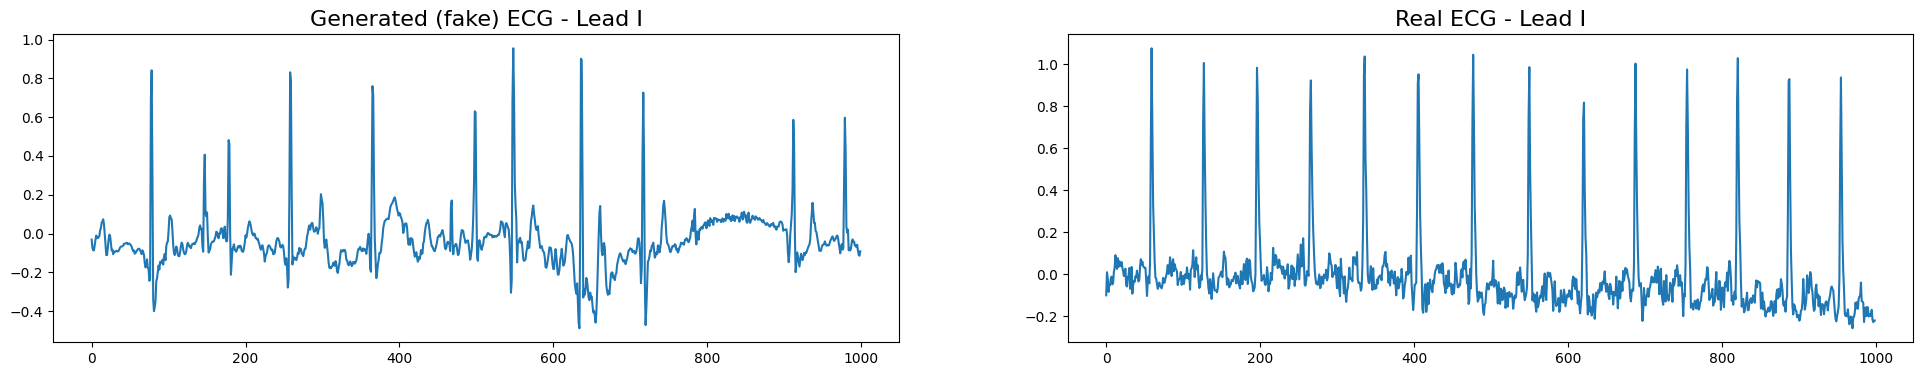

Generator AUROC: 0.953125
Generator loss: 0.6895989
Descriminator AUROC: 0.533203125
Descriminator loss: 0.694354
epoch 182
epoch 183
epoch 184
epoch 185
epoch 186
epoch 187
epoch 188
epoch 189
epoch 190
epoch 191


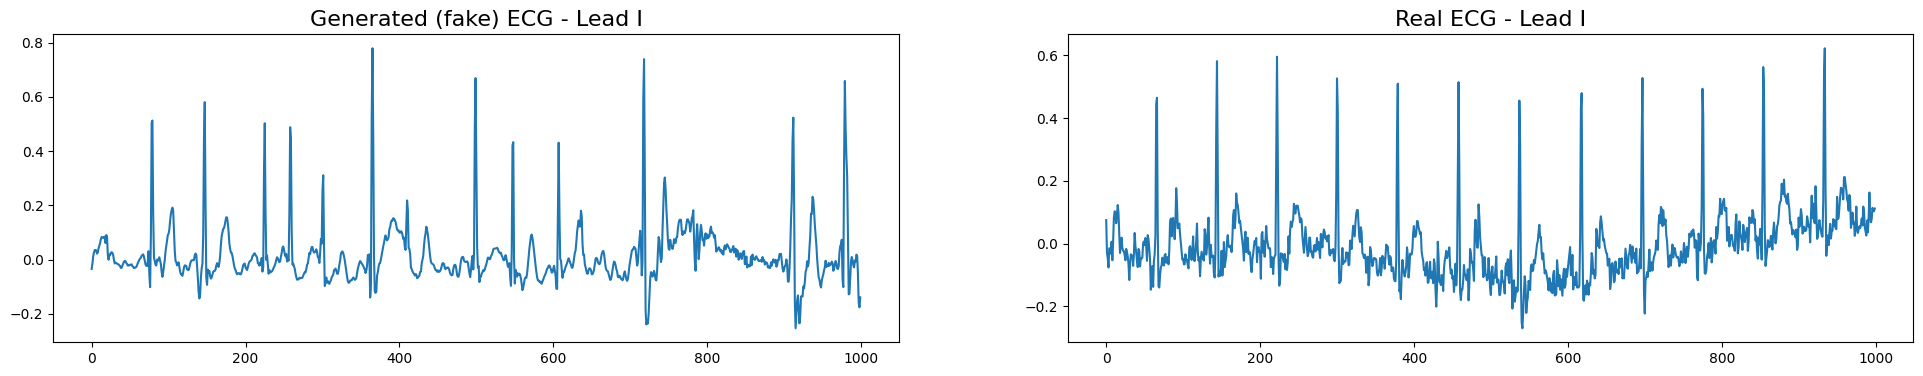

Generator AUROC: 0.8125
Generator loss: 0.6913742
Descriminator AUROC: 0.541015625
Descriminator loss: 0.6920275
epoch 192
epoch 193
epoch 194
epoch 195
epoch 196
epoch 197
epoch 198
epoch 199
epoch 200
epoch 201


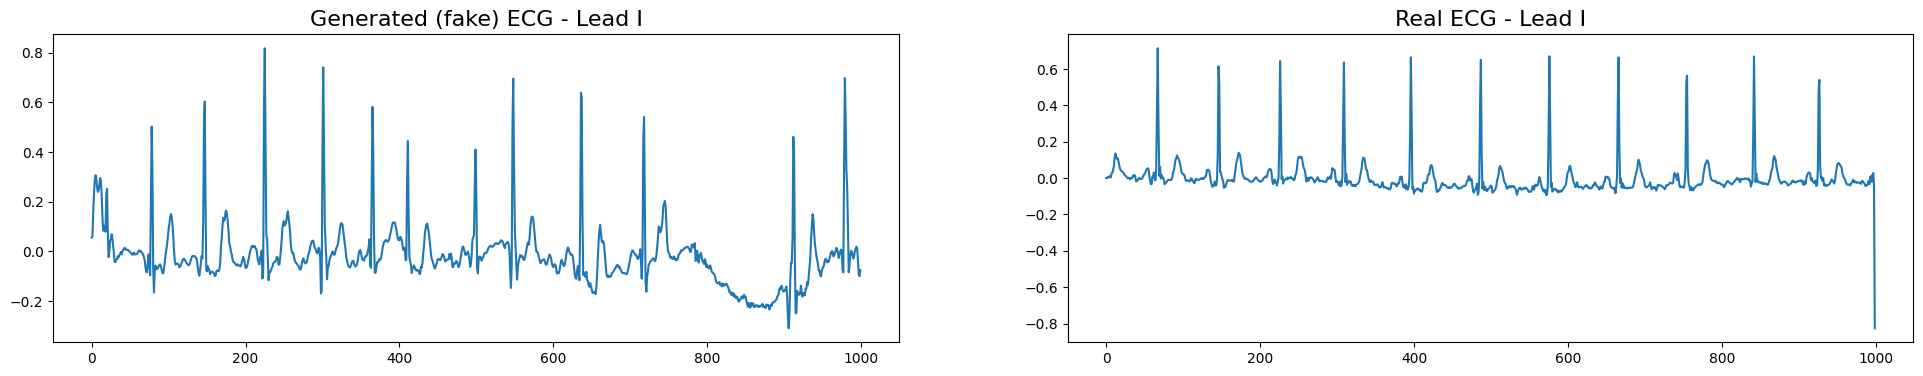

Generator AUROC: 0.484375
Generator loss: 0.69260734
Descriminator AUROC: 0.45654296875
Descriminator loss: 0.6924518
epoch 202
epoch 203
epoch 204
epoch 205
epoch 206
epoch 207
epoch 208
epoch 209
epoch 210
epoch 211


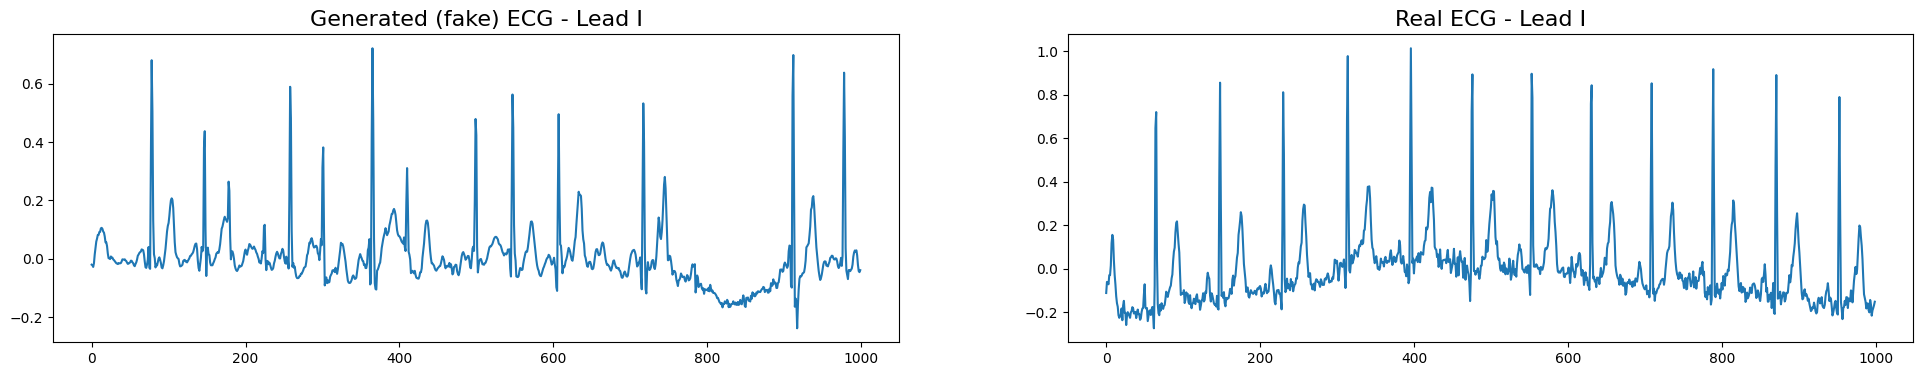

Generator AUROC: 0.484375
Generator loss: 0.6931645
Descriminator AUROC: 0.5537109375
Descriminator loss: 0.6921953
epoch 212
epoch 213
epoch 214
epoch 215
epoch 216
epoch 217
epoch 218
epoch 219
epoch 220
epoch 221


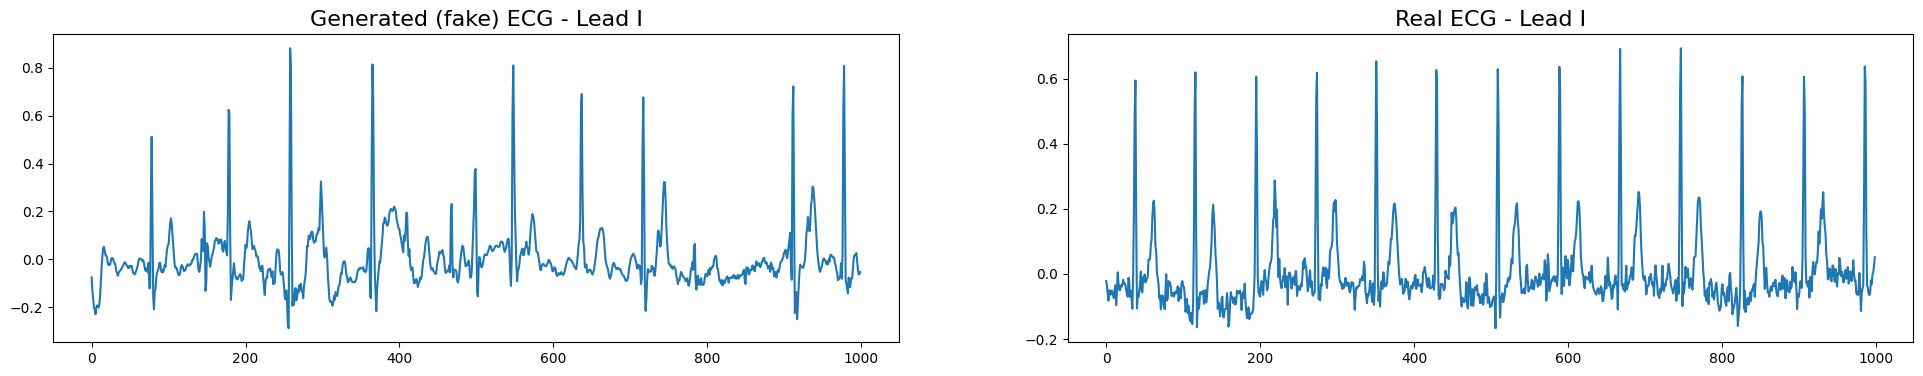

Generator AUROC: 0.78125
Generator loss: 0.6902605
Descriminator AUROC: 0.59765625
Descriminator loss: 0.6921611
epoch 222
epoch 223
epoch 224
epoch 225
epoch 226
epoch 227
epoch 228
epoch 229
epoch 230
epoch 231


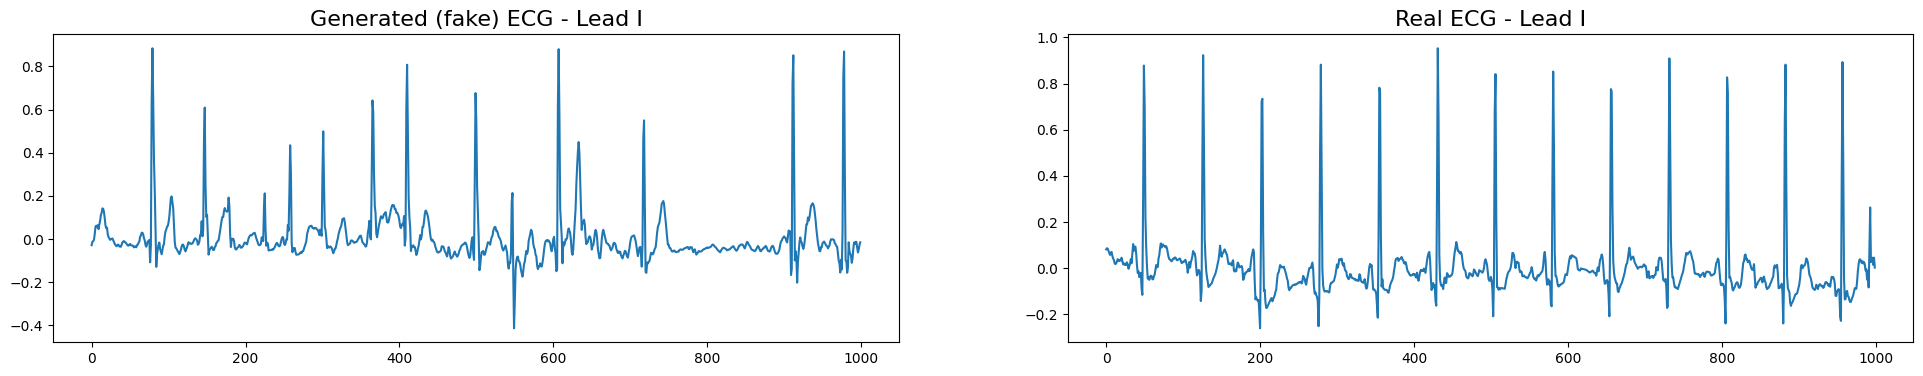

Generator AUROC: 0.96875
Generator loss: 0.68766886
Descriminator AUROC: 0.5751953125
Descriminator loss: 0.69360375
epoch 232
epoch 233
epoch 234
epoch 235
epoch 236
epoch 237
epoch 238
epoch 239
epoch 240
epoch 241


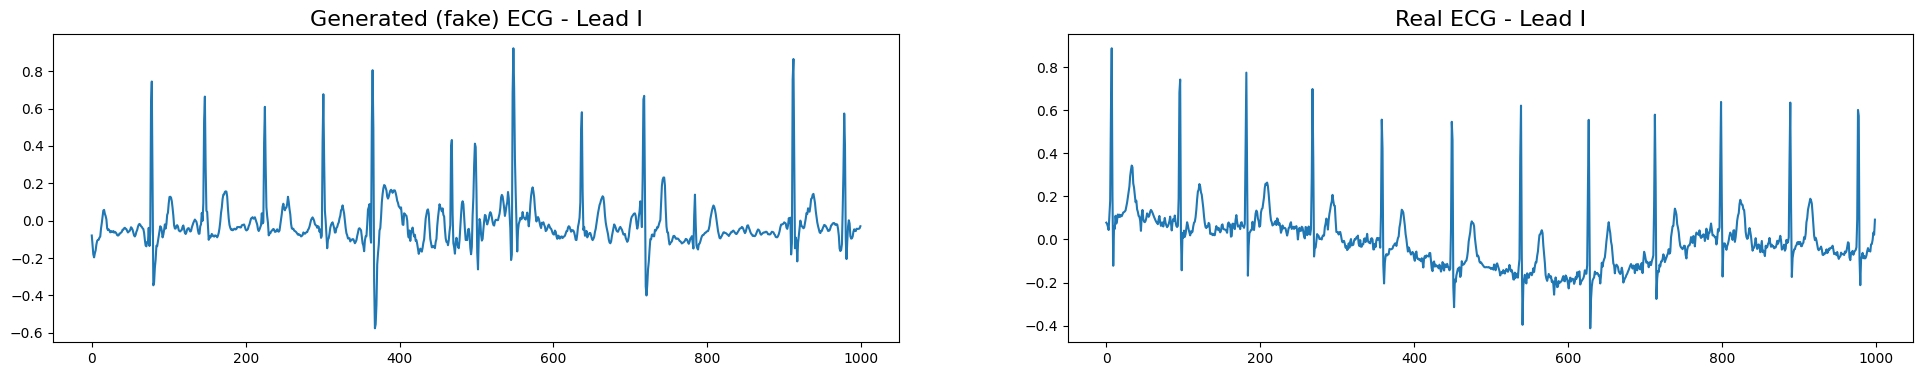

Generator AUROC: 0.90625
Generator loss: 0.68831515
Descriminator AUROC: 0.6025390625
Descriminator loss: 0.69416386
epoch 242
epoch 243
epoch 244
epoch 245
epoch 246
epoch 247
epoch 248
epoch 249
epoch 250
epoch 251


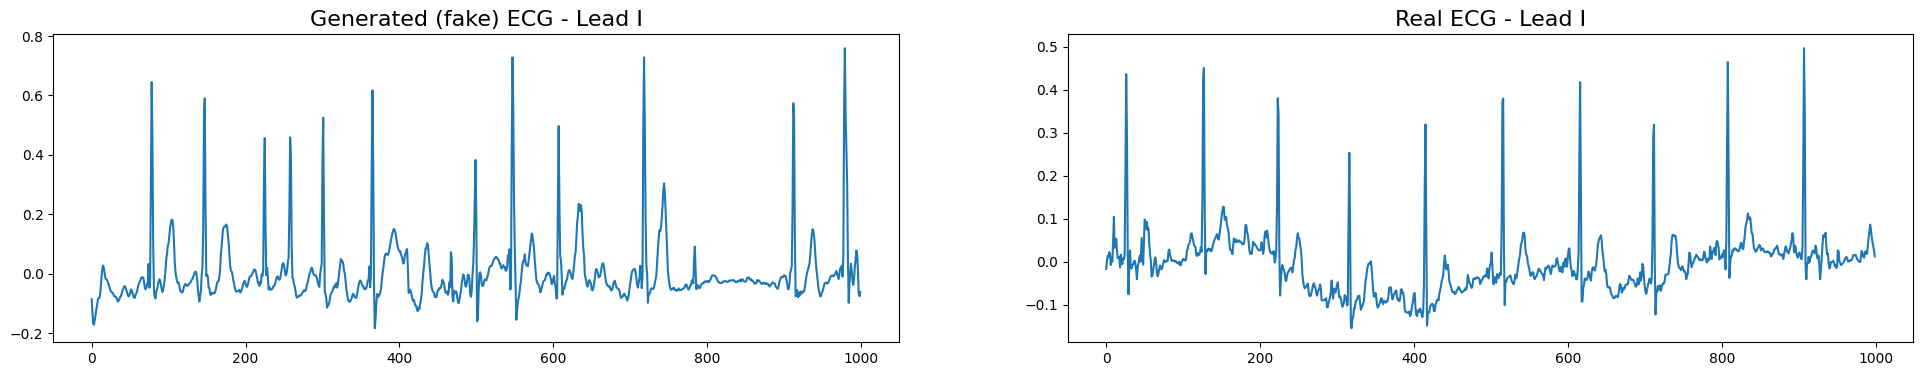

Generator AUROC: 0.84375
Generator loss: 0.6892535
Descriminator AUROC: 0.517578125
Descriminator loss: 0.69392926
epoch 252
epoch 253
epoch 254
epoch 255
epoch 256
epoch 257
epoch 258
epoch 259
epoch 260
epoch 261


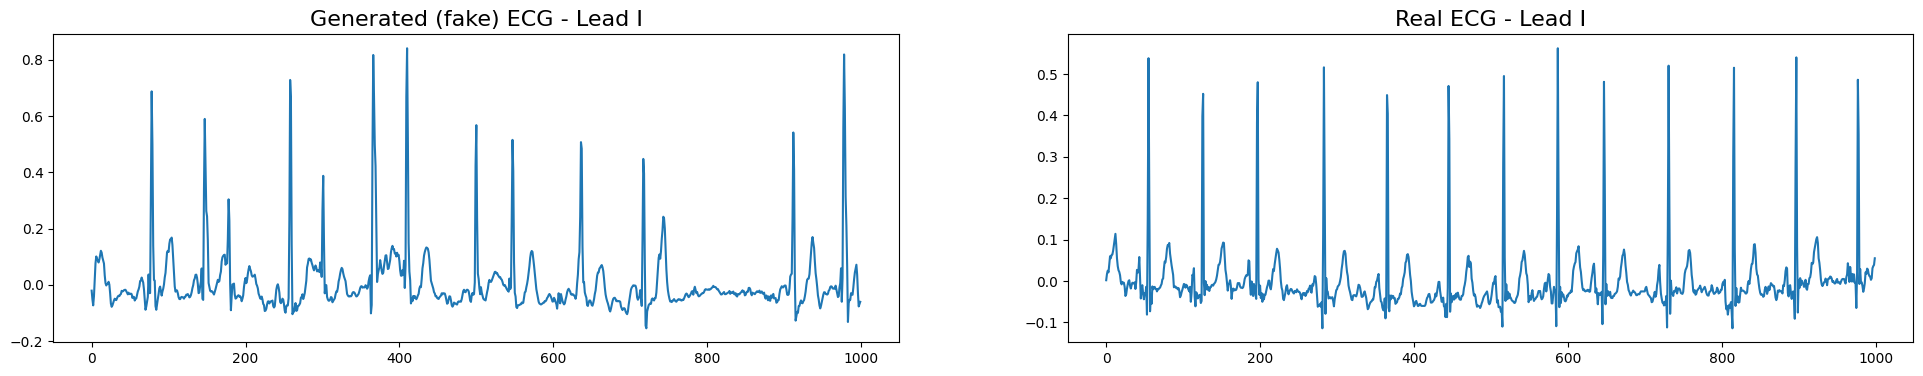

Generator AUROC: 0.6875
Generator loss: 0.68966943
Descriminator AUROC: 0.4287109375
Descriminator loss: 0.69415146
epoch 262
epoch 263
epoch 264
epoch 265
epoch 266
epoch 267
epoch 268
epoch 269
epoch 270
epoch 271


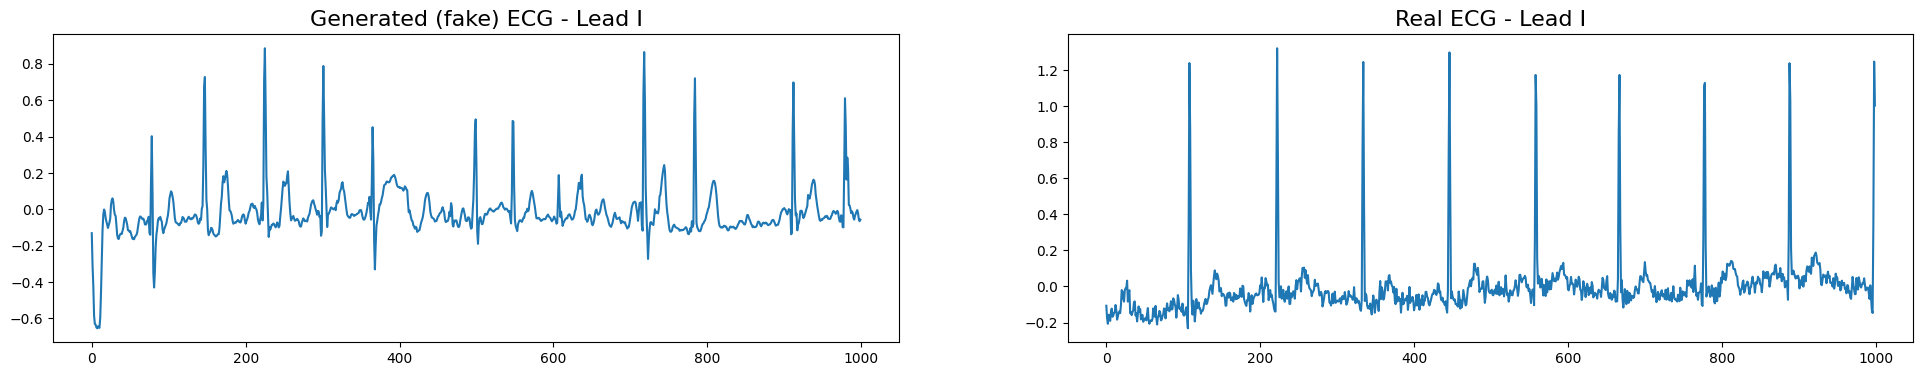

Generator AUROC: 0.65625
Generator loss: 0.6903175
Descriminator AUROC: 0.3681640625
Descriminator loss: 0.69344246
epoch 272
epoch 273
epoch 274
epoch 275
epoch 276
epoch 277
epoch 278
epoch 279
epoch 280
epoch 281


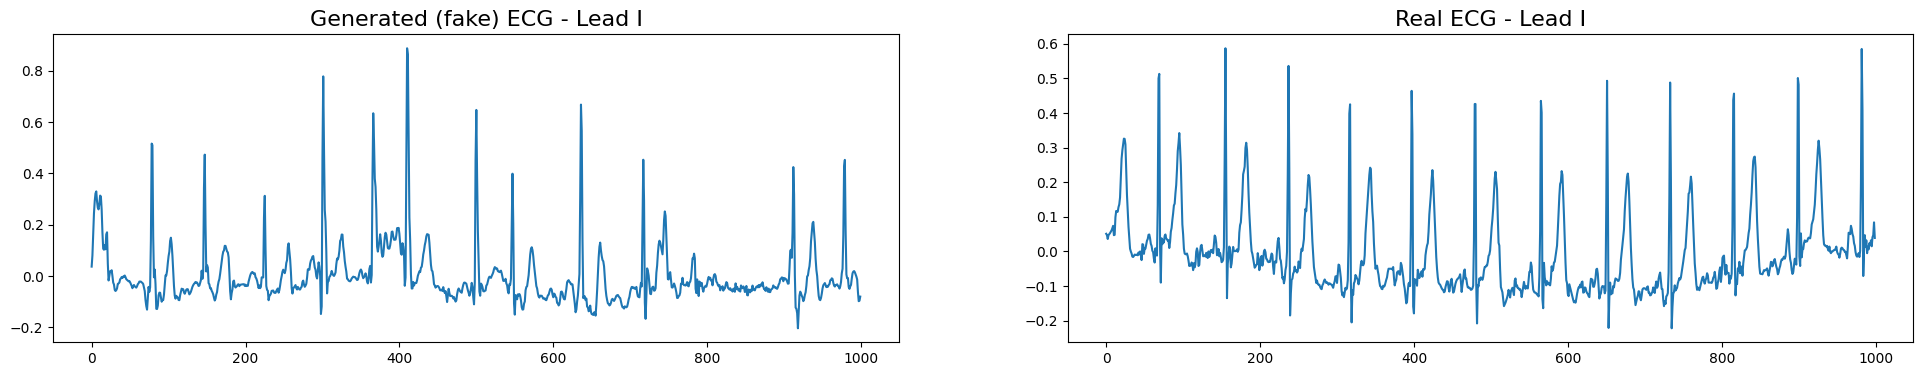

Generator AUROC: 0.6875
Generator loss: 0.69076383
Descriminator AUROC: 0.46875
Descriminator loss: 0.6940401
epoch 282
epoch 283
epoch 284
epoch 285
epoch 286
epoch 287
epoch 288
epoch 289
epoch 290
epoch 291


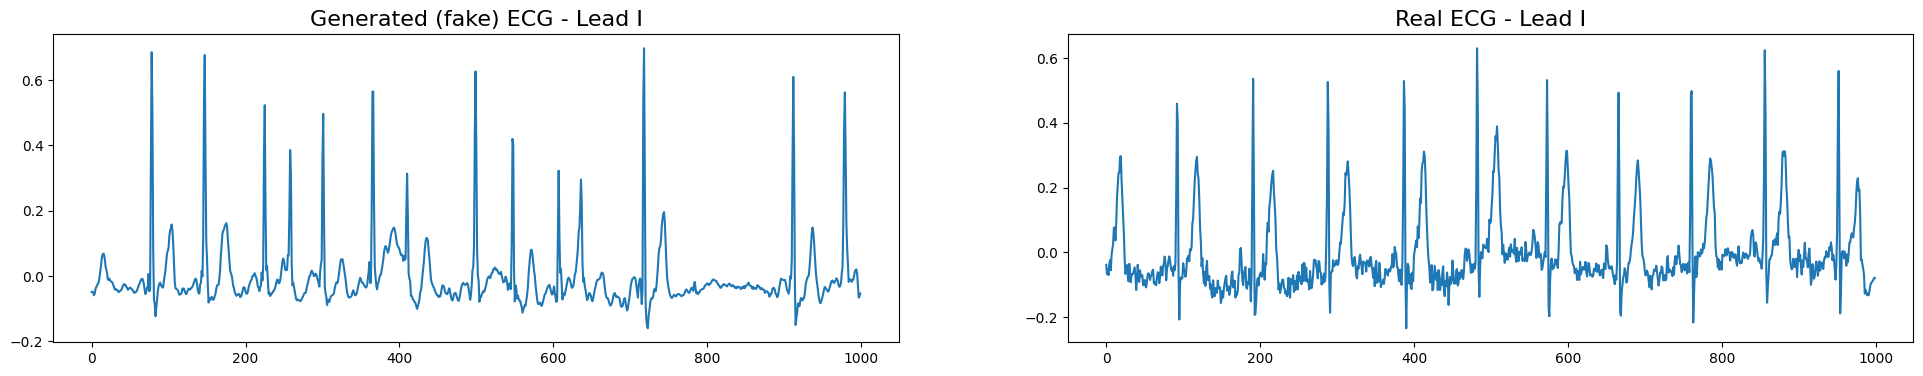

Generator AUROC: 0.5625
Generator loss: 0.691145
Descriminator AUROC: 0.533203125
Descriminator loss: 0.6947136
epoch 292
epoch 293
epoch 294
epoch 295
epoch 296
epoch 297
epoch 298
epoch 299
epoch 300
epoch 301


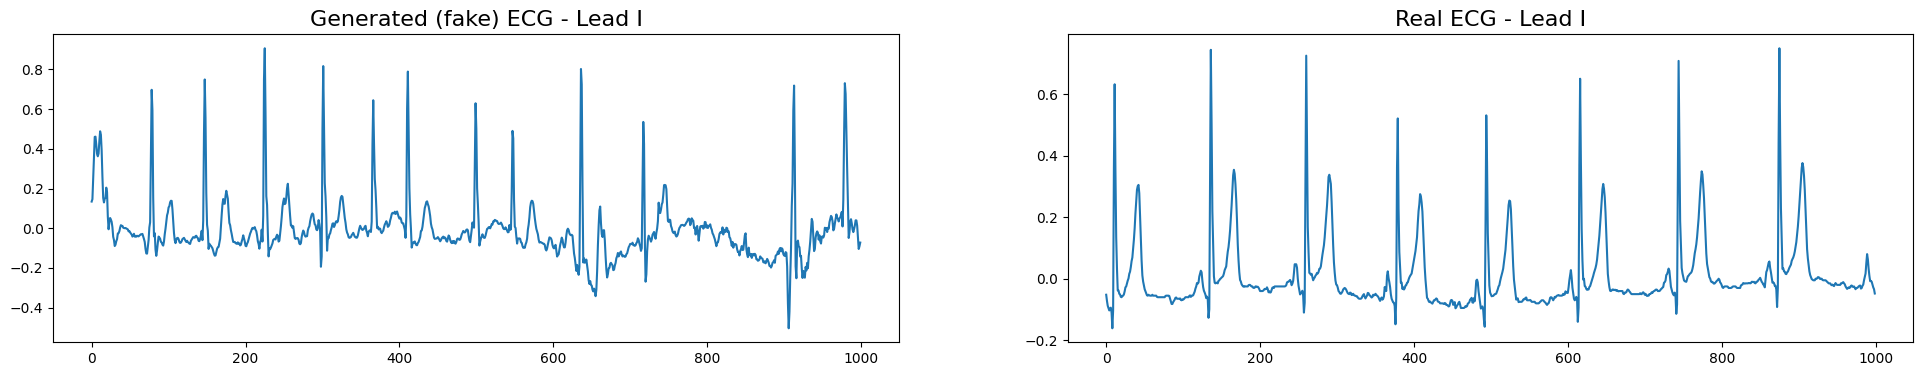

Generator AUROC: 0.5625
Generator loss: 0.6918068
Descriminator AUROC: 0.4541015625
Descriminator loss: 0.6940022
epoch 302
epoch 303
epoch 304
epoch 305
epoch 306
epoch 307
epoch 308
epoch 309
epoch 310
epoch 311


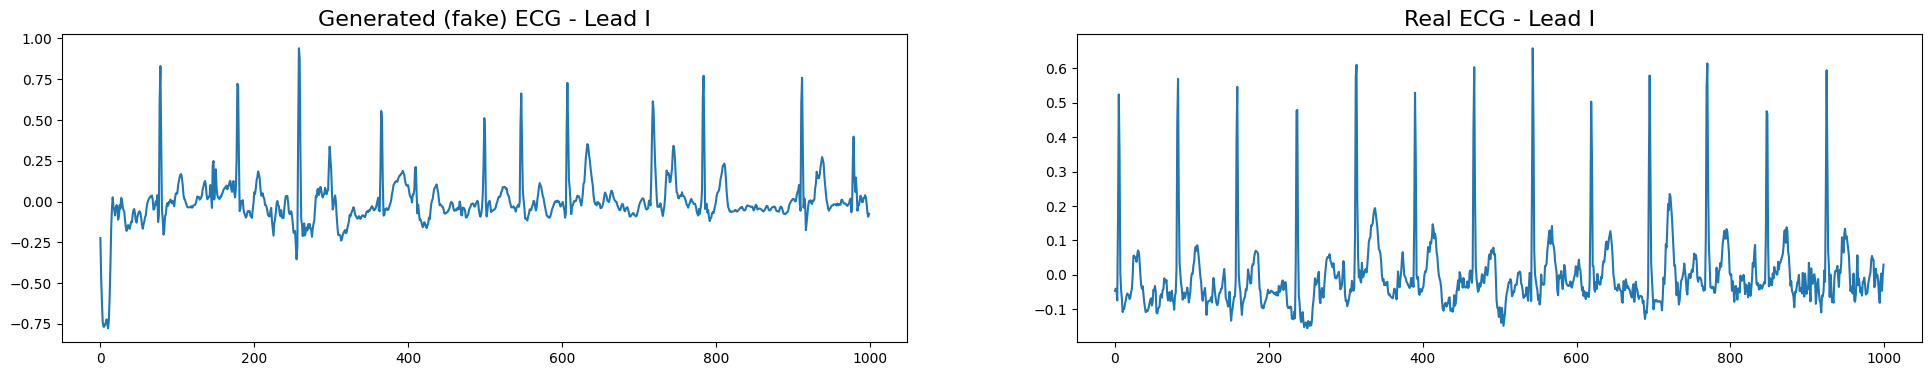

Generator AUROC: 0.46875
Generator loss: 0.6916737
Descriminator AUROC: 0.5302734375
Descriminator loss: 0.69354016
epoch 312
epoch 313
epoch 314
epoch 315
epoch 316
epoch 317
epoch 318
epoch 319
epoch 320
epoch 321


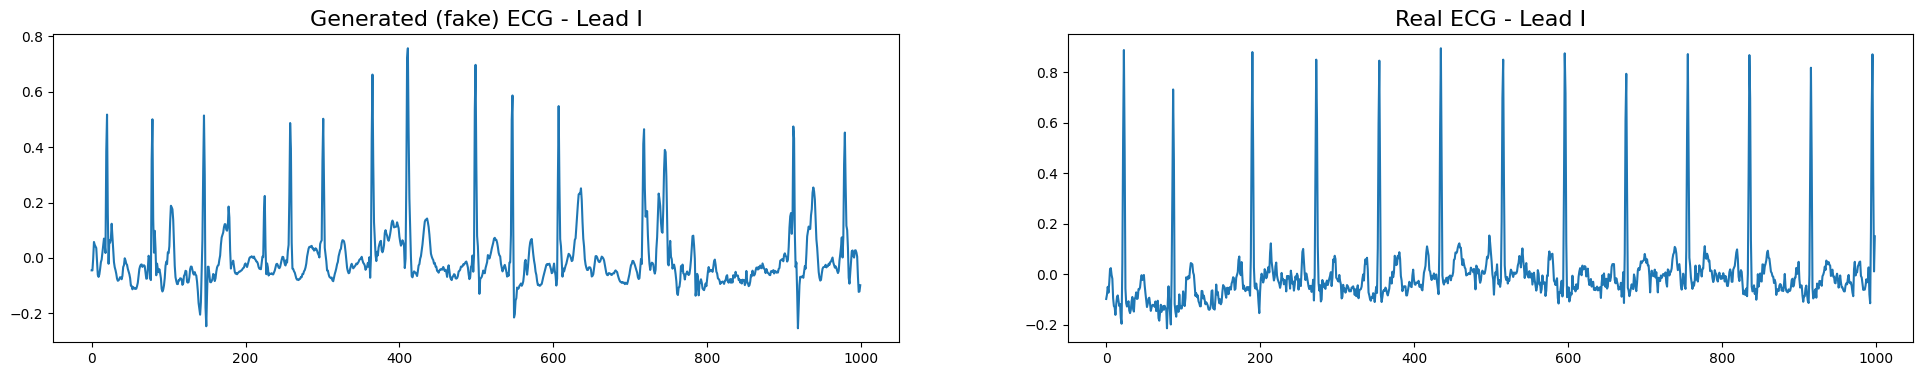

Generator AUROC: 0.453125
Generator loss: 0.692059
Descriminator AUROC: 0.423828125
Descriminator loss: 0.69394726
epoch 322
epoch 323
epoch 324
epoch 325
epoch 326
epoch 327
epoch 328
epoch 329
epoch 330
epoch 331


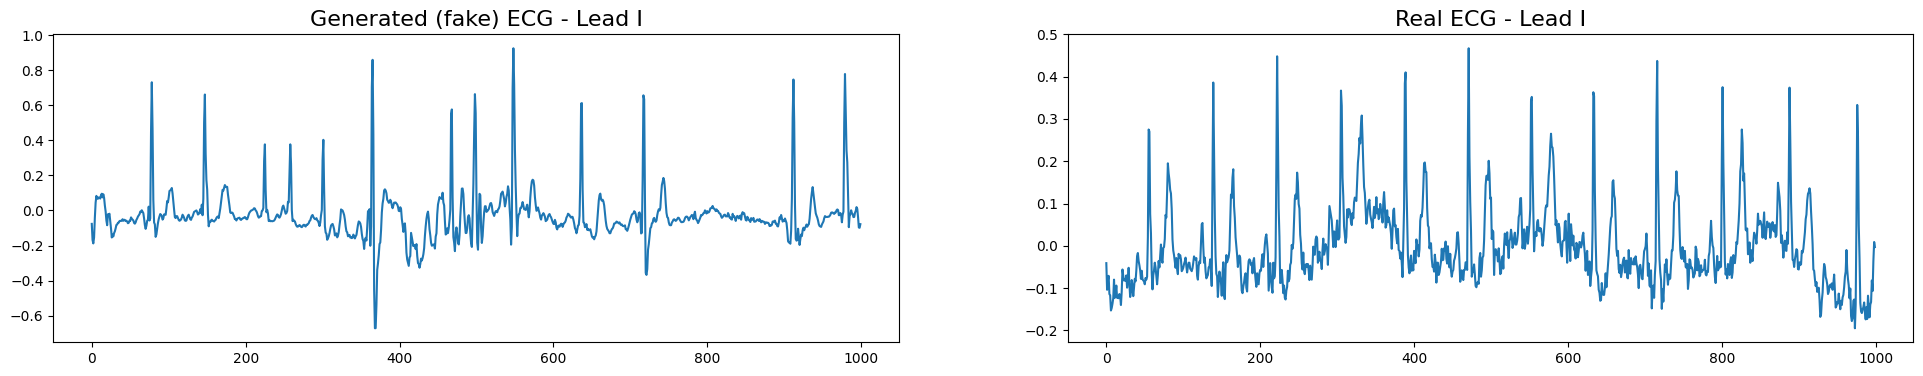

Generator AUROC: 0.453125
Generator loss: 0.6921084
Descriminator AUROC: 0.5732421875
Descriminator loss: 0.6936891
epoch 332
epoch 333
epoch 334
epoch 335
epoch 336
epoch 337
epoch 338
epoch 339
epoch 340
epoch 341


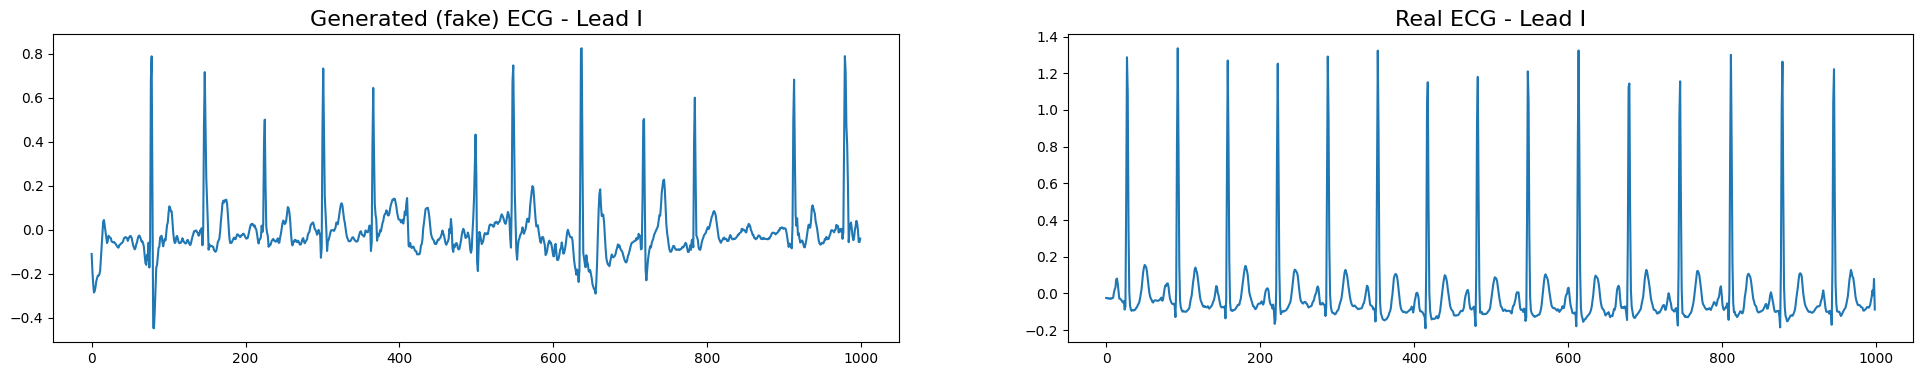

Generator AUROC: 0.453125
Generator loss: 0.6921922
Descriminator AUROC: 0.548828125
Descriminator loss: 0.6941283
epoch 342
epoch 343
epoch 344
epoch 345
epoch 346
epoch 347
epoch 348
epoch 349
epoch 350
epoch 351


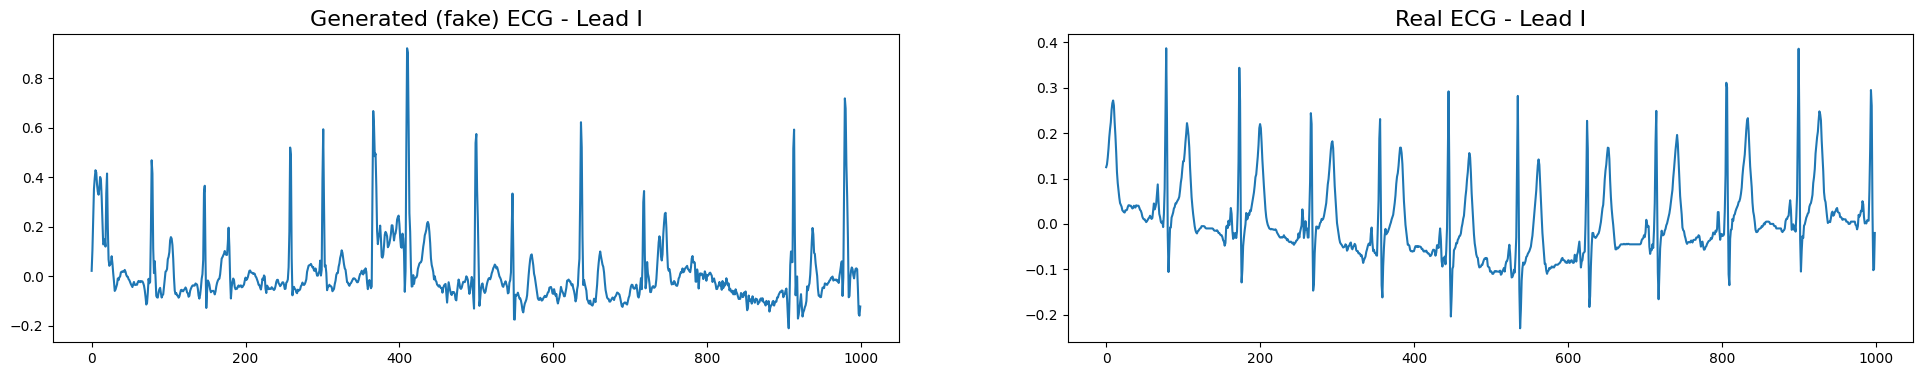

Generator AUROC: 0.390625
Generator loss: 0.6923411
Descriminator AUROC: 0.52734375
Descriminator loss: 0.6945203
epoch 352
epoch 353
epoch 354
epoch 355
epoch 356
epoch 357
epoch 358
epoch 359
epoch 360
epoch 361


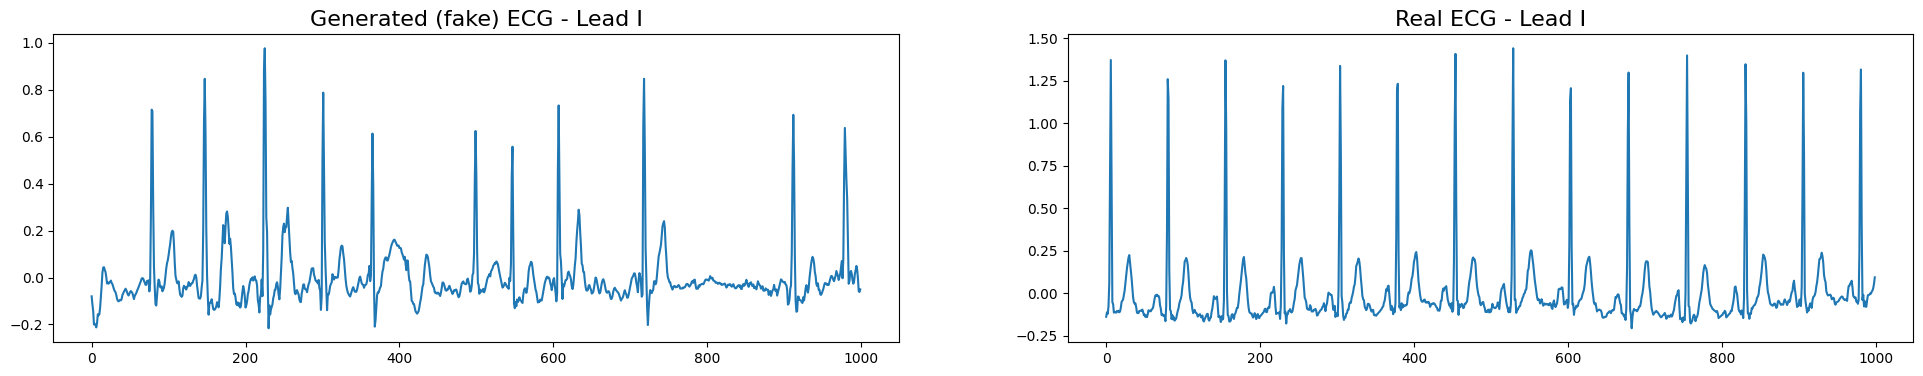

Generator AUROC: 0.40625
Generator loss: 0.69246
Descriminator AUROC: 0.59765625
Descriminator loss: 0.69360524
epoch 362
epoch 363
epoch 364
epoch 365
epoch 366
epoch 367
epoch 368
epoch 369
epoch 370
epoch 371


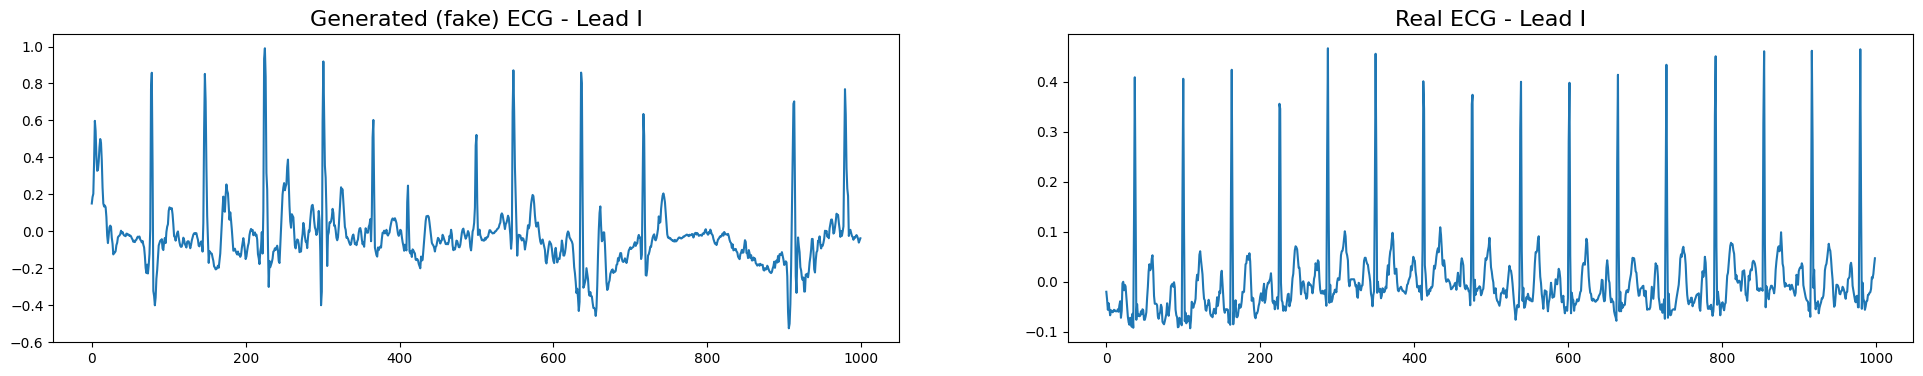

Generator AUROC: 0.515625
Generator loss: 0.6922277
Descriminator AUROC: 0.3876953125
Descriminator loss: 0.6936827
epoch 372
epoch 373
epoch 374
epoch 375
epoch 376
epoch 377
epoch 378
epoch 379
epoch 380
epoch 381


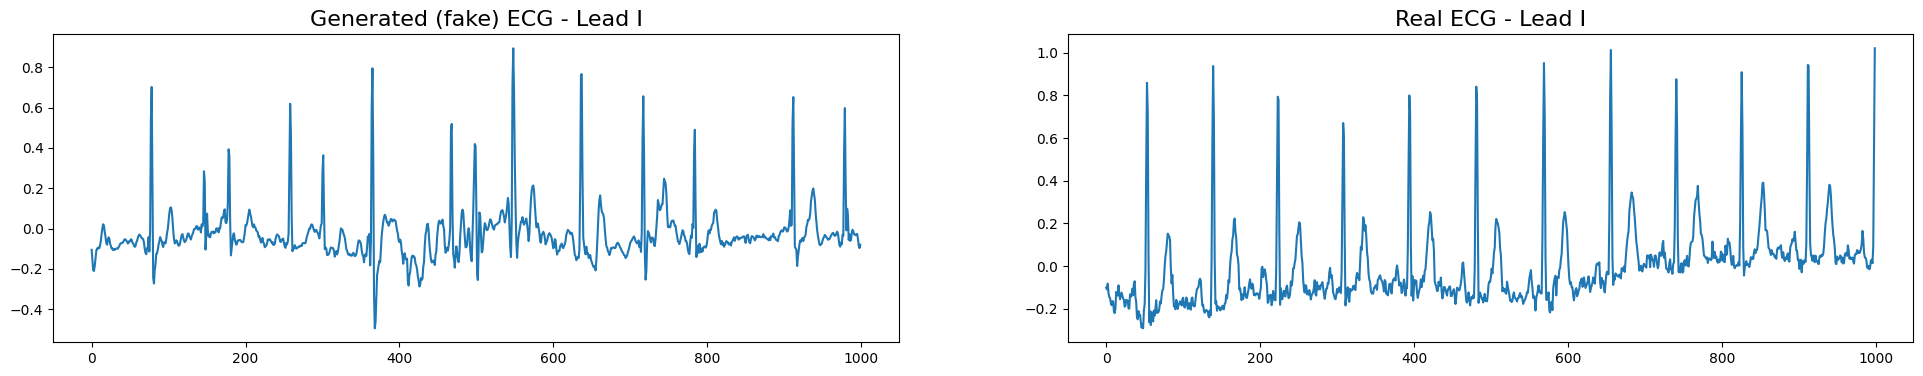

Generator AUROC: 0.4375
Generator loss: 0.69242305
Descriminator AUROC: 0.4951171875
Descriminator loss: 0.6938663
epoch 382
epoch 383
epoch 384
epoch 385
epoch 386
epoch 387
epoch 388
epoch 389
epoch 390
epoch 391


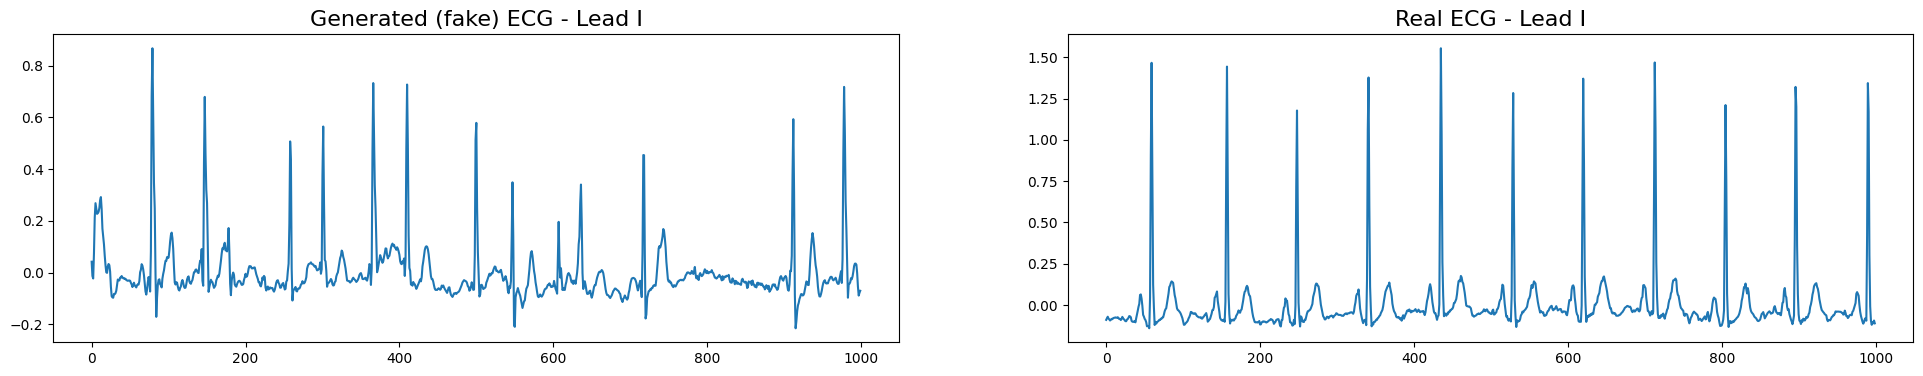

Generator AUROC: 0.421875
Generator loss: 0.69232017
Descriminator AUROC: 0.5107421875
Descriminator loss: 0.6947585
epoch 392
epoch 393
epoch 394
epoch 395
epoch 396
epoch 397
epoch 398
epoch 399
epoch 400
epoch 401


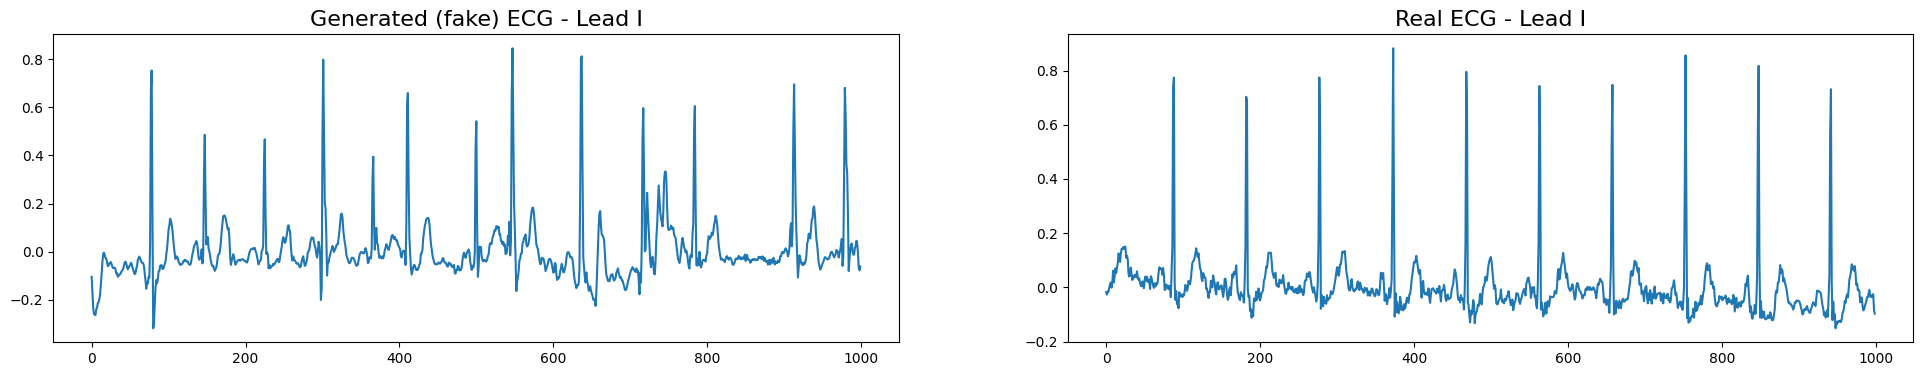

Generator AUROC: 0.53125
Generator loss: 0.6924431
Descriminator AUROC: 0.5517578125
Descriminator loss: 0.6938396
epoch 402
epoch 403
epoch 404
epoch 405
epoch 406
epoch 407
epoch 408
epoch 409
epoch 410
epoch 411


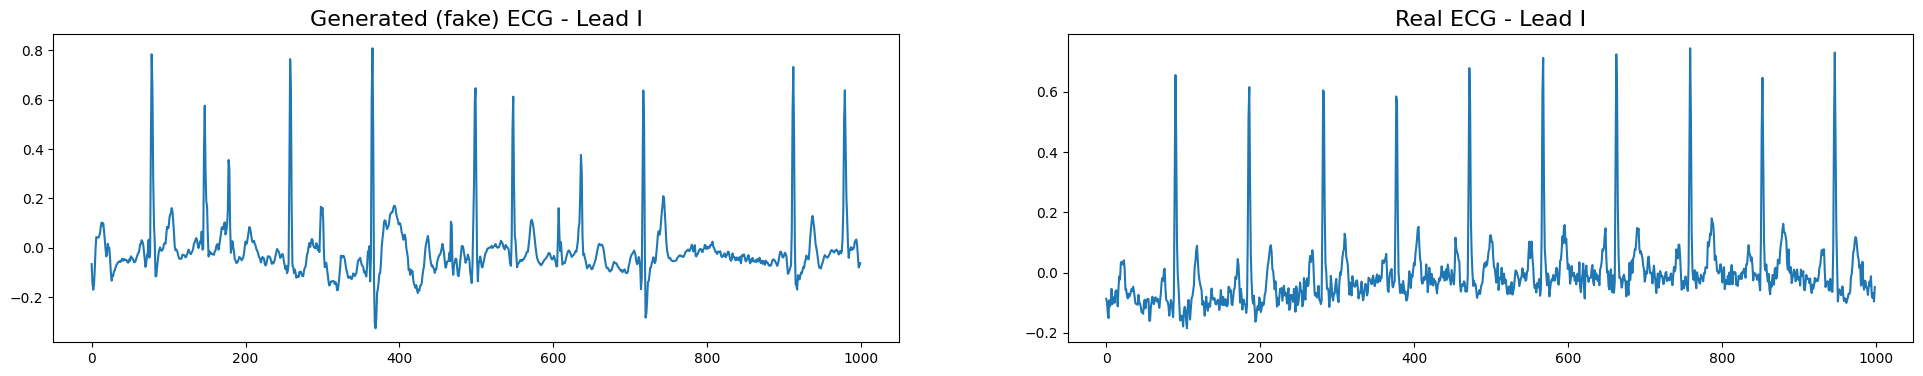

Generator AUROC: 0.40625
Generator loss: 0.692599
Descriminator AUROC: 0.5205078125
Descriminator loss: 0.69369674
epoch 412
epoch 413
epoch 414
epoch 415
epoch 416
epoch 417
epoch 418
epoch 419
epoch 420
epoch 421


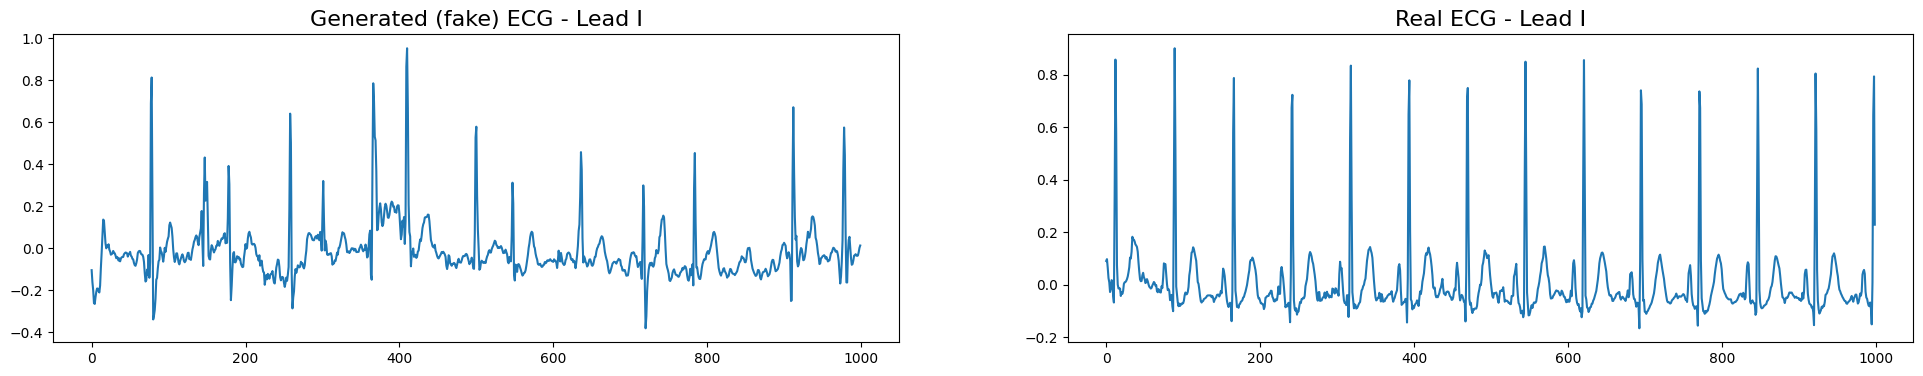

Generator AUROC: 0.359375
Generator loss: 0.69260466
Descriminator AUROC: 0.525390625
Descriminator loss: 0.69421685
epoch 422
epoch 423
epoch 424
epoch 425
epoch 426
epoch 427
epoch 428
epoch 429
epoch 430
epoch 431


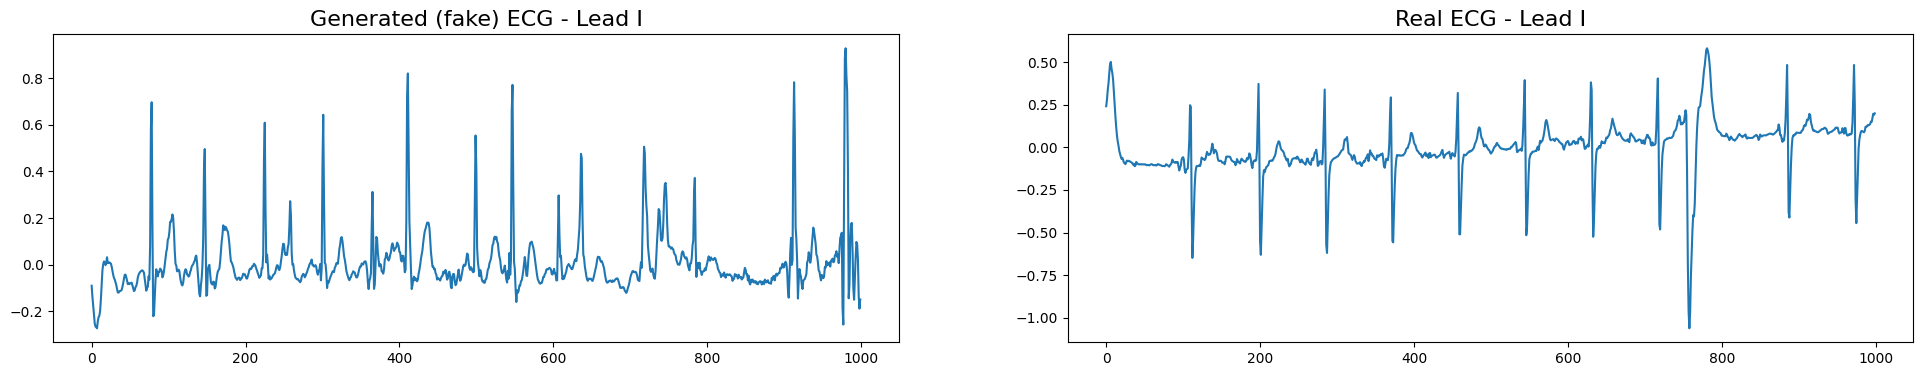

Generator AUROC: 0.484375
Generator loss: 0.6924502
Descriminator AUROC: 0.513671875
Descriminator loss: 0.6939085
epoch 432
epoch 433
epoch 434
epoch 435
epoch 436
epoch 437
epoch 438
epoch 439
epoch 440
epoch 441


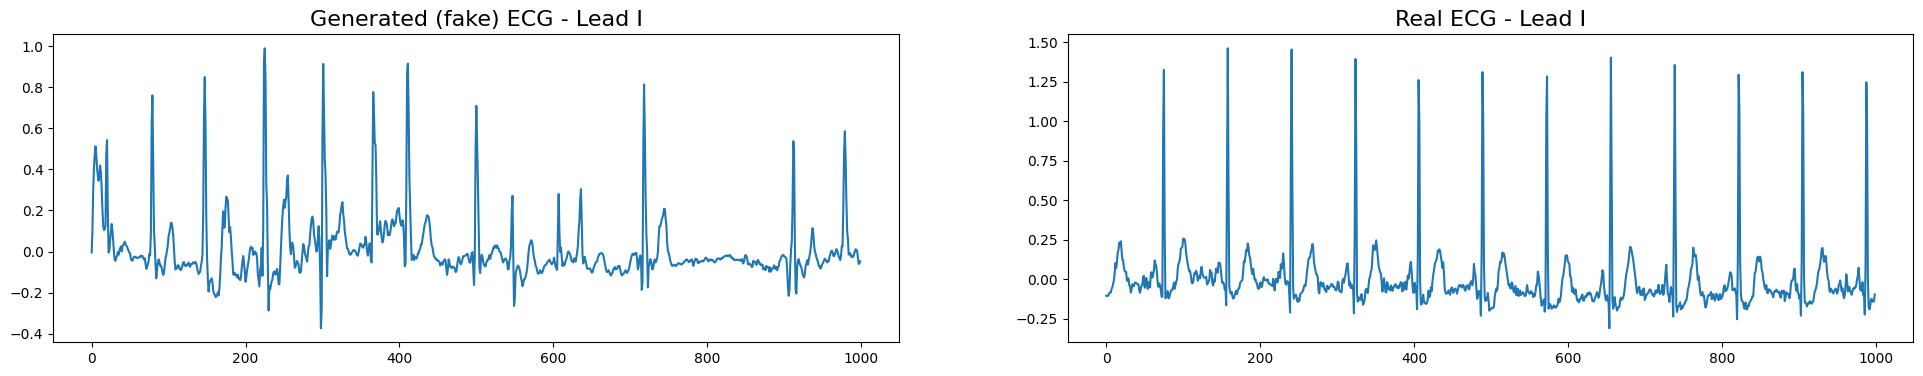

Generator AUROC: 0.40625
Generator loss: 0.69239455
Descriminator AUROC: 0.583984375
Descriminator loss: 0.69400495
epoch 442
epoch 443
epoch 444
epoch 445
epoch 446
epoch 447
epoch 448
epoch 449
epoch 450
epoch 451


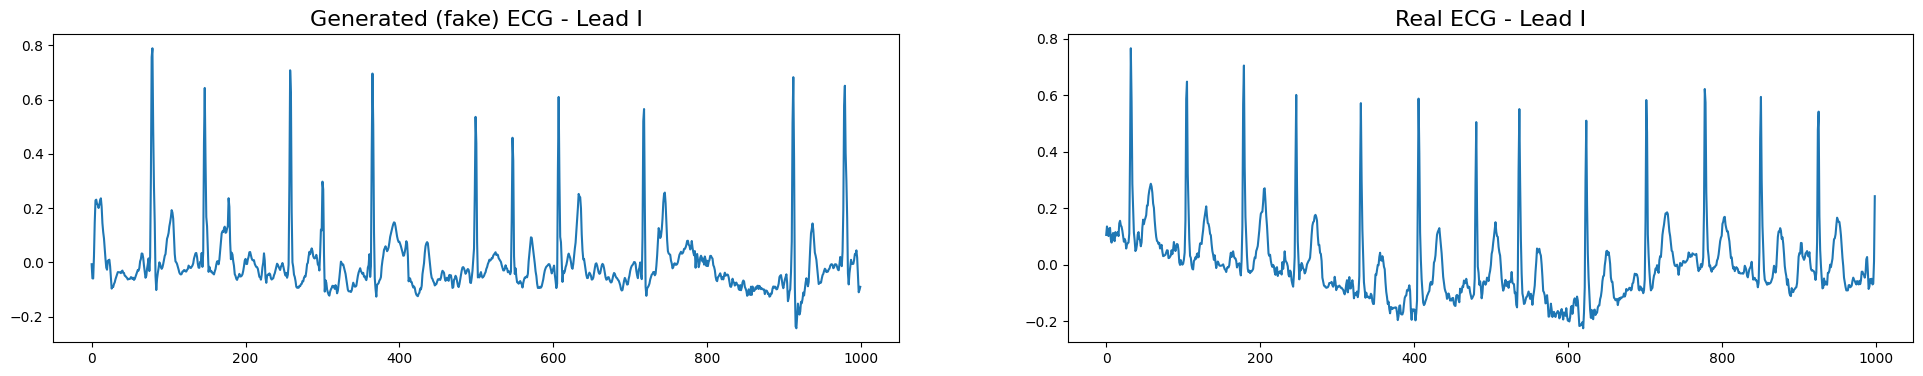

Generator AUROC: 0.4375
Generator loss: 0.69252294
Descriminator AUROC: 0.3720703125
Descriminator loss: 0.69357955
epoch 452
epoch 453
epoch 454
epoch 455
epoch 456
epoch 457
epoch 458
epoch 459
epoch 460
epoch 461


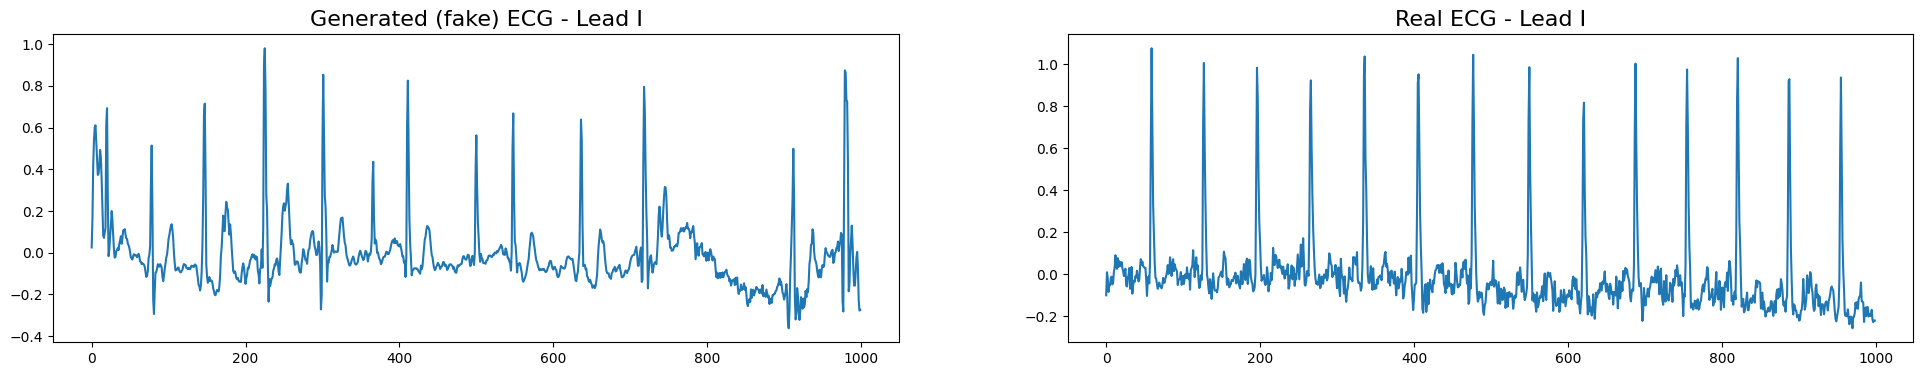

Generator AUROC: 0.421875
Generator loss: 0.6927765
Descriminator AUROC: 0.4619140625
Descriminator loss: 0.69441897
epoch 462
epoch 463
epoch 464
epoch 465
epoch 466
epoch 467
epoch 468
epoch 469
epoch 470
epoch 471


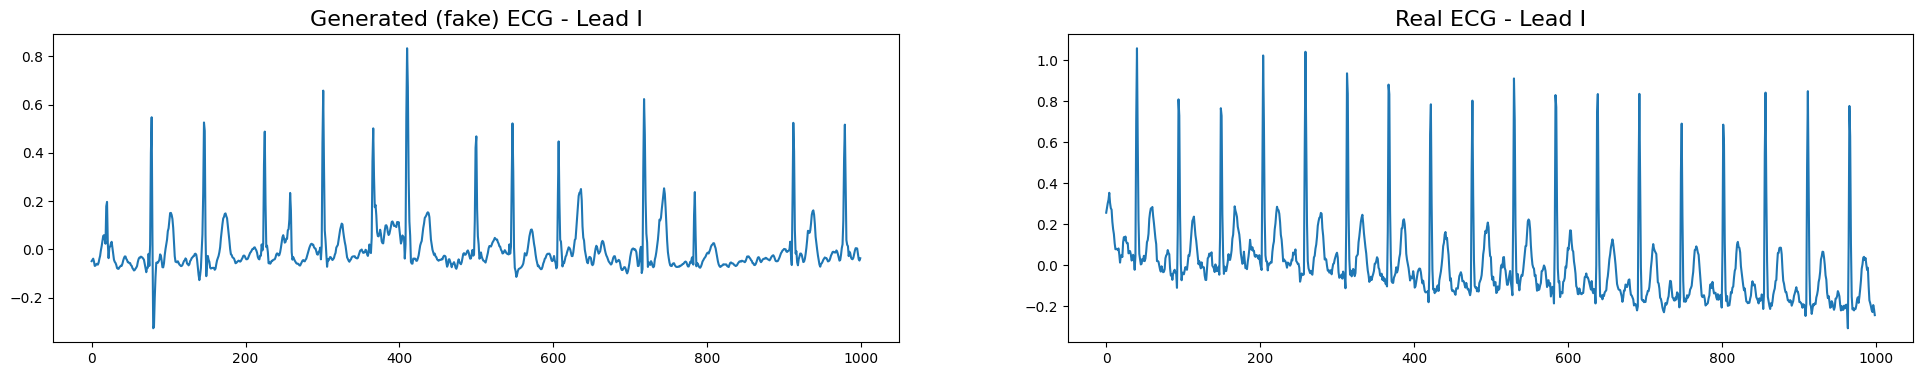

Generator AUROC: 0.4375
Generator loss: 0.6927119
Descriminator AUROC: 0.5205078125
Descriminator loss: 0.6939796
epoch 472
epoch 473
epoch 474
epoch 475
epoch 476
epoch 477
epoch 478
epoch 479
epoch 480
epoch 481


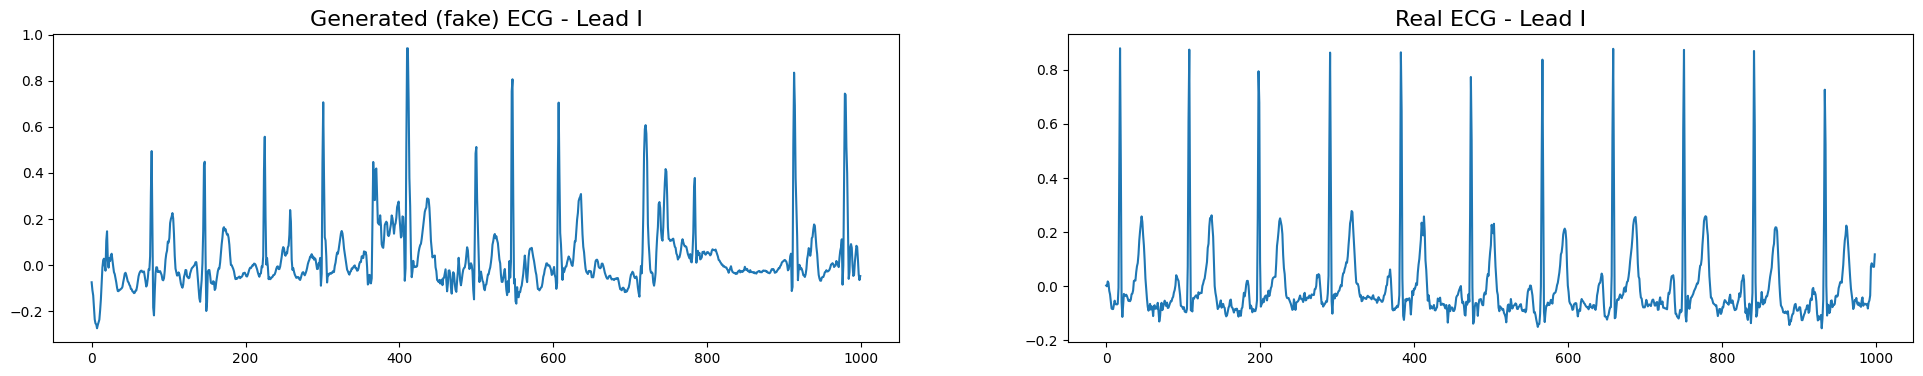

Generator AUROC: 0.265625
Generator loss: 0.6924449
Descriminator AUROC: 0.4892578125
Descriminator loss: 0.69414324
epoch 482
epoch 483
epoch 484
epoch 485
epoch 486
epoch 487
epoch 488
epoch 489
epoch 490
epoch 491


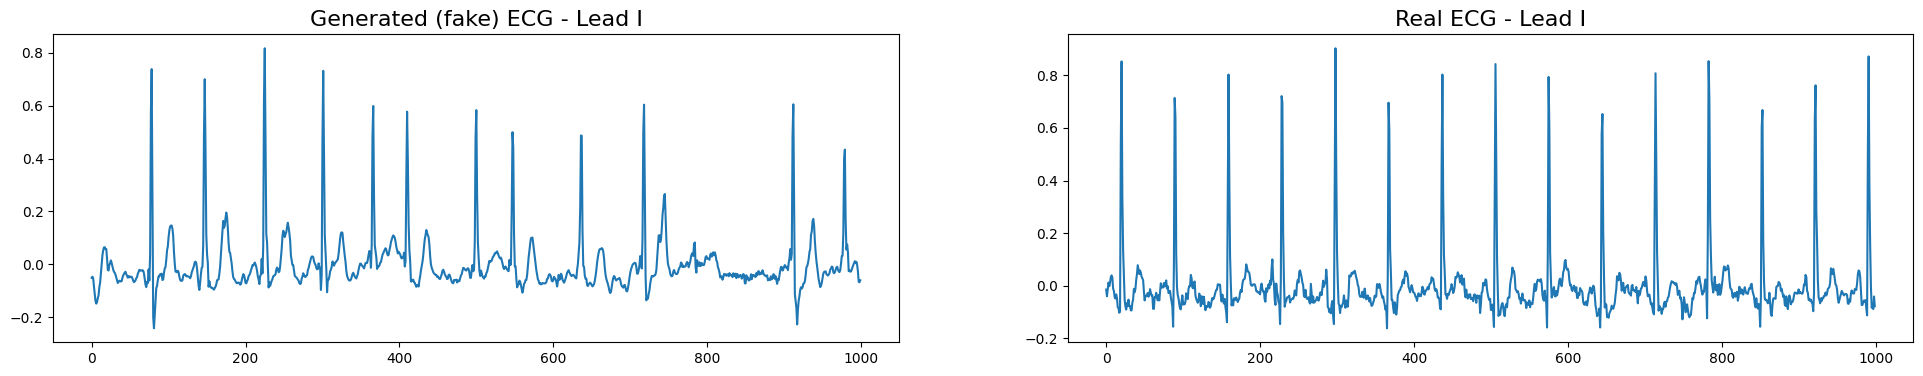

Generator AUROC: 0.3125
Generator loss: 0.69253635
Descriminator AUROC: 0.53076171875
Descriminator loss: 0.6941753
epoch 492
epoch 493
epoch 494
epoch 495
epoch 496
epoch 497
epoch 498
epoch 499


In [130]:
batch_size=64
latent_dim=12
steps = len(X_sub)//batch_size
half_batch = batch_size // 2
epochs = 500
#gen = generator()
#desc = discriminator()
init_lr_desc = 0.001
init_lr_gen = 0.002
opt_desc = tf.keras.optimizers.Adam(learning_rate=init_lr_desc,beta_1=0.5, beta_2=0.9)
opt_gen = tf.keras.optimizers.Adam(learning_rate=init_lr_gen,beta_1=0.5, beta_2=0.9)
print("Before training:")
res = gen(generate_latent_points(12,1))
compare_real_and_gen_ecg(res)
print("-------------------")
for epoch in range(epochs):
    if epoch % 25 == True:
        init_lr_desc = init_lr_desc/2
        init_lr_gen = init_lr_gen/2
        opt_desc.lr = init_lr_desc
        opt_gen.lr = init_lr_gen
    accu_loss_gan = []
    accu_loss_desc = []
    print("epoch {}".format(epoch))
    for step in range(steps):
        x_real, y_real = generate_real_samples(X_sub,half_batch)
        x_fake, y_fake = generate_fake_samples(latent_dim,gen,half_batch)
        X_train = np.vstack([x_real,x_fake])
        y_train = np.vstack([y_real,y_fake])
        p = np.random.permutation(len(y_train)) #shuffle

        with tf.GradientTape() as tape:
            pred_desc = desc(X_train[p])
            loss_desc = tf.keras.losses.binary_crossentropy(y_train[p], pred_desc)
        accu_loss_desc.append(loss_desc)
        grads = tape.gradient(loss_desc, desc.trainable_variables)
        opt_desc.apply_gradients(zip(grads, desc.trainable_variables))
        

        with tf.GradientTape() as tape:
            x_latent = generate_latent_points(latent_dim,batch_size)
            x_gan = gen(x_latent)
            y_gan = np.ones((batch_size, 1))
            pred_gan = desc(x_gan)
            loss_gan = tf.keras.losses.binary_crossentropy(y_gan, pred_gan)
        accu_loss_gan.append(loss_gan)
        grads = tape.gradient(loss_gan, gen.trainable_variables)
        opt_gen.apply_gradients(zip(grads, gen.trainable_variables))
        #summarize_performance(1,gen, desc, latent_dim, ECGs) 
    if(epoch % 10 == 1 ):
        res = gen(generate_latent_points(12,1))
        compare_real_and_gen_ecg(res)
        print("Generator AUROC:", roc_auc_score(np.concatenate([y_gan.ravel(),np.array([0])]),np.concatenate([np.asarray(pred_gan).ravel(),np.array([0.5])])))
        print("Generator loss:", np.mean(np.asarray(accu_loss_gan)))
        print("Descriminator AUROC:", roc_auc_score(y_train.ravel(),np.asarray(pred_desc).ravel()))   
        print("Descriminator loss:", np.mean(np.asarray(accu_loss_desc)))

In [131]:
gen.save_weights("gen2_weights.h5")

In [132]:
desc.save_weights("disc2_weights.h5")